In [1]:
# Random Forest Feature Selection for Selenkay Models
# Running full models in R with mgcv
# For the moment, just running feature selection here with random forests
# PB 11/10/22

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from pathlib import Path
import geopandas as gpd


# makes matplotlib plots big
plt.rcParams['figure.figsize'] = [24, 12]
plt.rcParams.update({'font.size': 14})

In [2]:
# Read data from R SelenkayDiversity directory
# (data was cleaned in R after being created in python)
XY_scale = pd.read_csv('/n/home02/pbb/scripts/SelenkayDiversity/data/in/XY_scaled.csv')
XY = pd.read_csv('/n/home02/pbb/scripts/SelenkayDiversity/data/in/XY.csv')
# Drop factor and character arrays from X df
X = XY_scale.drop(['Unnamed: 0', 'Spot', 'Richness',
                   'Abundance', 'Soil', 'Soil_f', 'Treatment', 'Treatment_f',
                   'Transect_f', 'nlayers_plot_f', 'shannonH'], axis=1)
X = X.dropna(axis=1)

In [3]:
y = XY_scale.filter(['Spot', 'Abundance', 'Richness', 'shannonH', 'Transect'])
y.head()

,Spot,Abundance,Richness,shannonH
0,10A,165,41,3.242139
1,10B,146,29,2.933800
2,10C,133,32,3.151907
3,10D,202,40,3.196626
4,10E,196,51,3.663820


In [4]:
X.columns

Index(['max_maxH', 'mean_maxH', 'sd_maxH', 'cv_maxH', 'median_maxH',
       'iqr_maxH', 'mean_sdH', 'sd_sdH', 'mean_cvH', 'sd_cvH',
       ...
       'mean_CD_Ggrasslayer', 'sd_CD_Ggrasslayer', 'cv_CD_Ggrasslayer',
       'median_CD_Ggrasslayer', 'iqr_CD_Ggrasslayer',
       'mean_CD_AboveGgrasslayer', 'sd_CD_AboveGgrasslayer',
       'cv_CD_AboveGgrasslayer', 'iqr_CD_AboveGgrasslayer',
       'max_CD_AboveGgrasslayer'],
      dtype='object', length=159)

In [5]:
X.dropna(axis=1).columns

Index(['max_maxH', 'mean_maxH', 'sd_maxH', 'cv_maxH', 'median_maxH',
       'iqr_maxH', 'mean_sdH', 'sd_sdH', 'mean_cvH', 'sd_cvH',
       ...
       'mean_CD_Ggrasslayer', 'sd_CD_Ggrasslayer', 'cv_CD_Ggrasslayer',
       'median_CD_Ggrasslayer', 'iqr_CD_Ggrasslayer',
       'mean_CD_AboveGgrasslayer', 'sd_CD_AboveGgrasslayer',
       'cv_CD_AboveGgrasslayer', 'iqr_CD_AboveGgrasslayer',
       'max_CD_AboveGgrasslayer'],
      dtype='object', length=159)

In [6]:
# Also, open up shapefile and add these vars in
# just to have a spatial representation of variables (as polygons)

radius=30

# Shapefile of Plots (for iterively setting boundaries of the grid)
# NOTE: This is the dissolved file without a buffer
# each feature is a plot polygon, marked by Site and Block number
shpf = Path(f'/n/home02/pbb/scripts/halo-metadata-server/Selenkay/data/in/BoundaryShapefiles/SelenkaySpotPolygons_IncreasingRadius/SelenkaySpotPolygons_{radius}mRadius.shp')
shpdf = gpd.read_file(shpf)

# Fix up 3A (3a)
shpdf.replace('3a', '3A', inplace=True)
# shpdf.head()

# Add Spot column to X for the merge
X_spot = XY.drop(['Unnamed: 0', 'Richness',
                   'Abundance', 'Soil', 'Soil_f', 'Treatment', 'Treatment_f',
                   'Transect_f', 'nlayers_plot_f', 'shannonH'], axis=1)
# X_spot.head()

# merge with y df on Spot column
shpdf_y = shpdf.merge(y)
shpdf_x = shpdf.merge(X_spot)

# Write to shapefile
shpdf_y.to_file('./data/out/Shapefiles/SelenkayBirdModels_Y.shp')
shpdf_x.to_file('./data/out/Shapefiles/SelenkayBirdModels_X.shp')

# Zip it
# !zip ./data/out/BirdDivModels_Shapefiles.zip ./data/out/Shapefiles/*

/n/home02/pbb/.conda/envs/Halo/lib/python3.8/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/tmp/ipykernel_145276/3604851607.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shpdf_x.to_file('./data/out/SelenkayBirdModels_X.shp')


In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     XY_scale.shannonH,
#                                                     random_state=42)

In [7]:
def featureSelectRF(X, y, feat=''):
    # # # 1 - Feature Selection with Random Forest Regressor and Gini Impurity
    # NOTE: the below is literally copy and pasted from:
    # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        random_state=42)
    
    forest = RandomForestRegressor(random_state=0)
    forest.fit(X_train, y_train)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=X_train.columns)
    
    mdi_top10 = forest_importances.sort_values(ascending=False)[:10].copy(deep=True)
    
    fig1, ax1 = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax1)
    ax1.set_title(f"{feat} Feature importances using MDI")
    ax1.set_ylabel("Mean decrease in impurity")
    fig1.tight_layout()
    
    result = permutation_importance(forest, X_test, y_test,
                                    n_repeats=10, random_state=42, n_jobs=2)
    
    
    forest_importances = pd.Series(result.importances_mean, index=X_train.columns)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title(f"{feat} importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    plt.show()
    
    permute_top10 = forest_importances.sort_values(ascending=False)[:10]
    
    print('\n\n')
    
    print(f'{feat} MDI Top 6 X Vars:\n')
    
    for m in mdi_top10.index:
        print(f'\t{m}')
        
    print('\n')
    
    print(f'{feat} Permutation Top 6 X Vars:\n')
    for m in permute_top10.index:
        print(f'\t{m}')
        
    print('\n\n')
    
    return mdi_top10, permute_top10, fig1, ax1, fig, ax

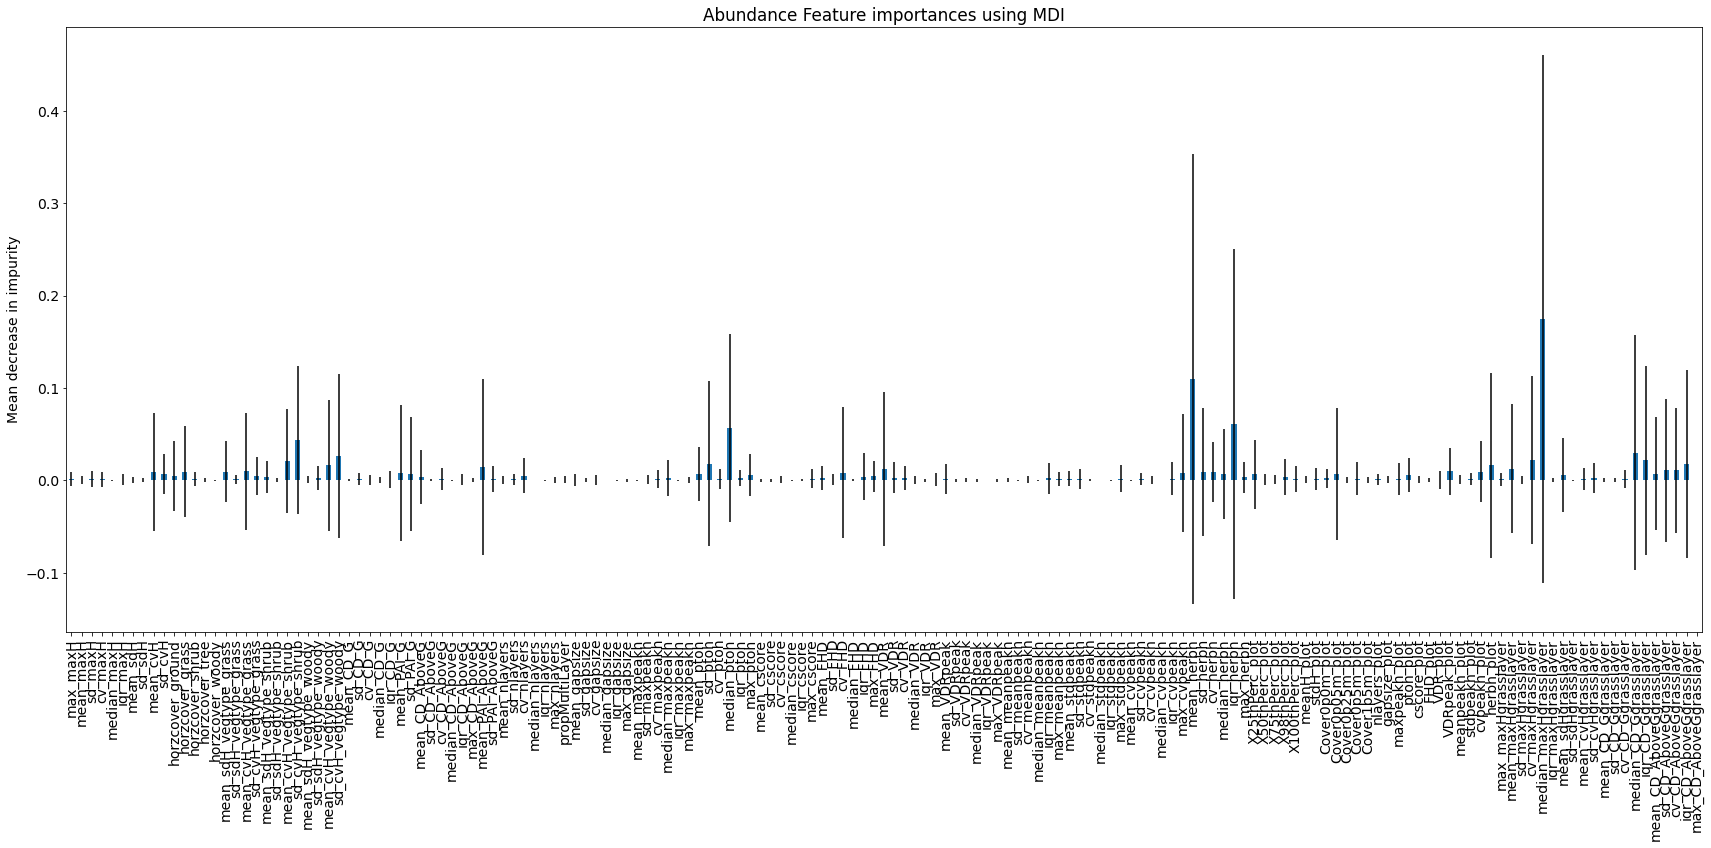

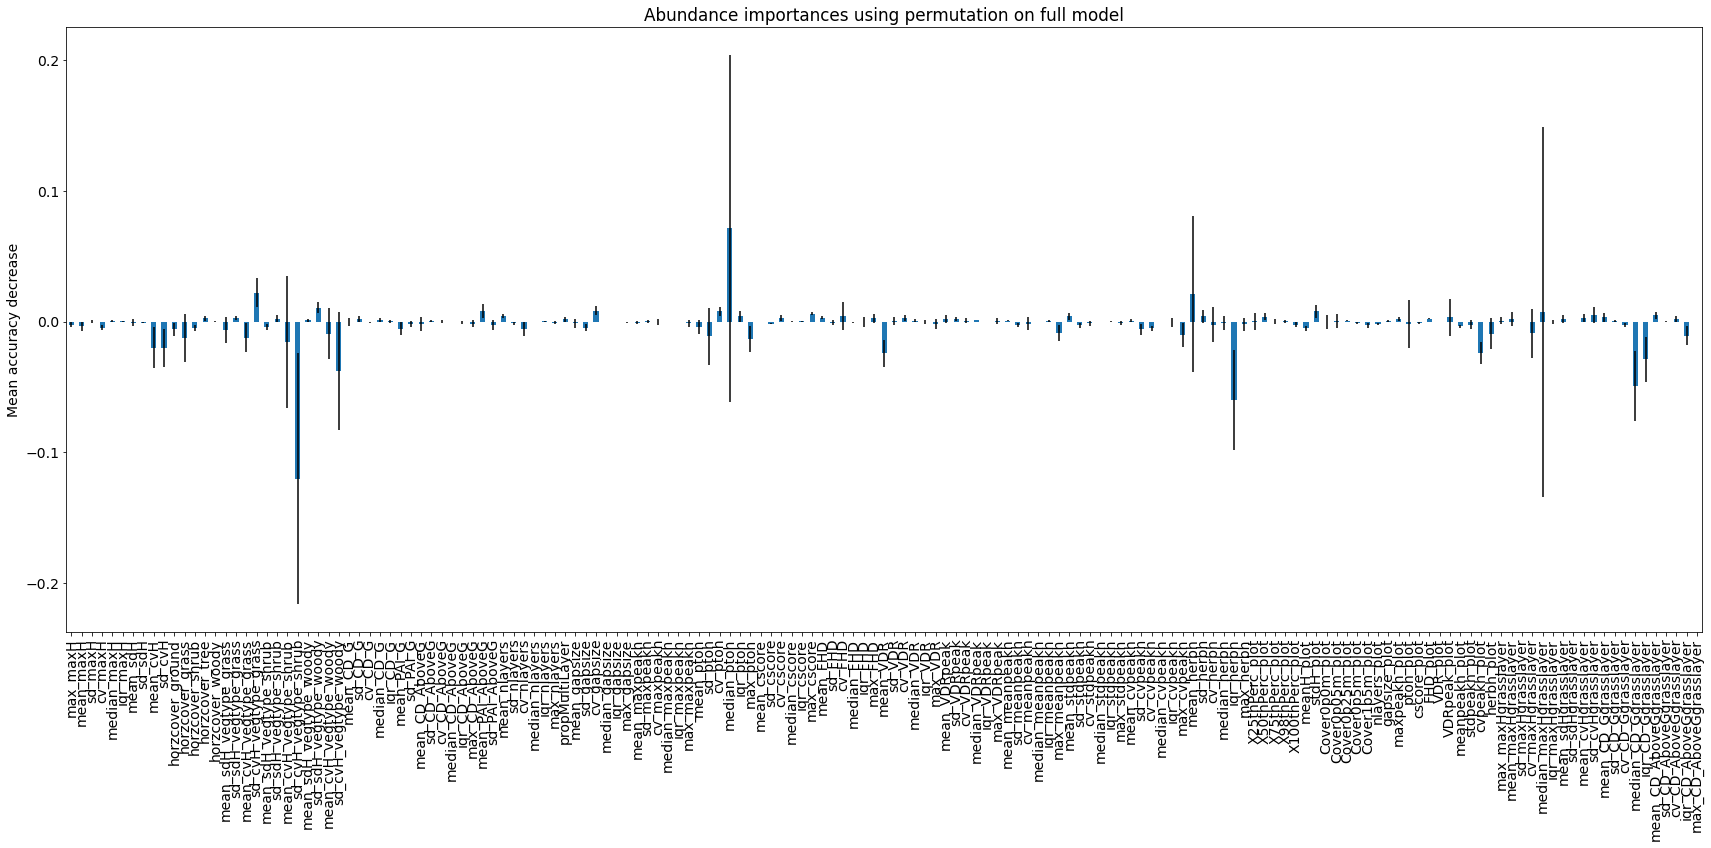




Abundance MDI Top 6 X Vars:

	median_maxHgrasslayer
	mean_herbh
	iqr_herbh
	median_ptoh
	sd_cvH_vegtype_shrub
	median_CD_Ggrasslayer
	sd_cvH_vegtype_woody
	iqr_CD_Ggrasslayer
	cv_maxHgrasslayer
	mean_cvH_vegtype_shrub


Abundance Permutation Top 6 X Vars:

	median_ptoh
	sd_cvH_vegtype_grass
	mean_herbh
	sd_sdH_vegtype_woody
	cv_gapsize
	mean_PAI_AboveG
	stdH_plot
	cv_ptoh
	median_maxHgrasslayer
	max_cscore





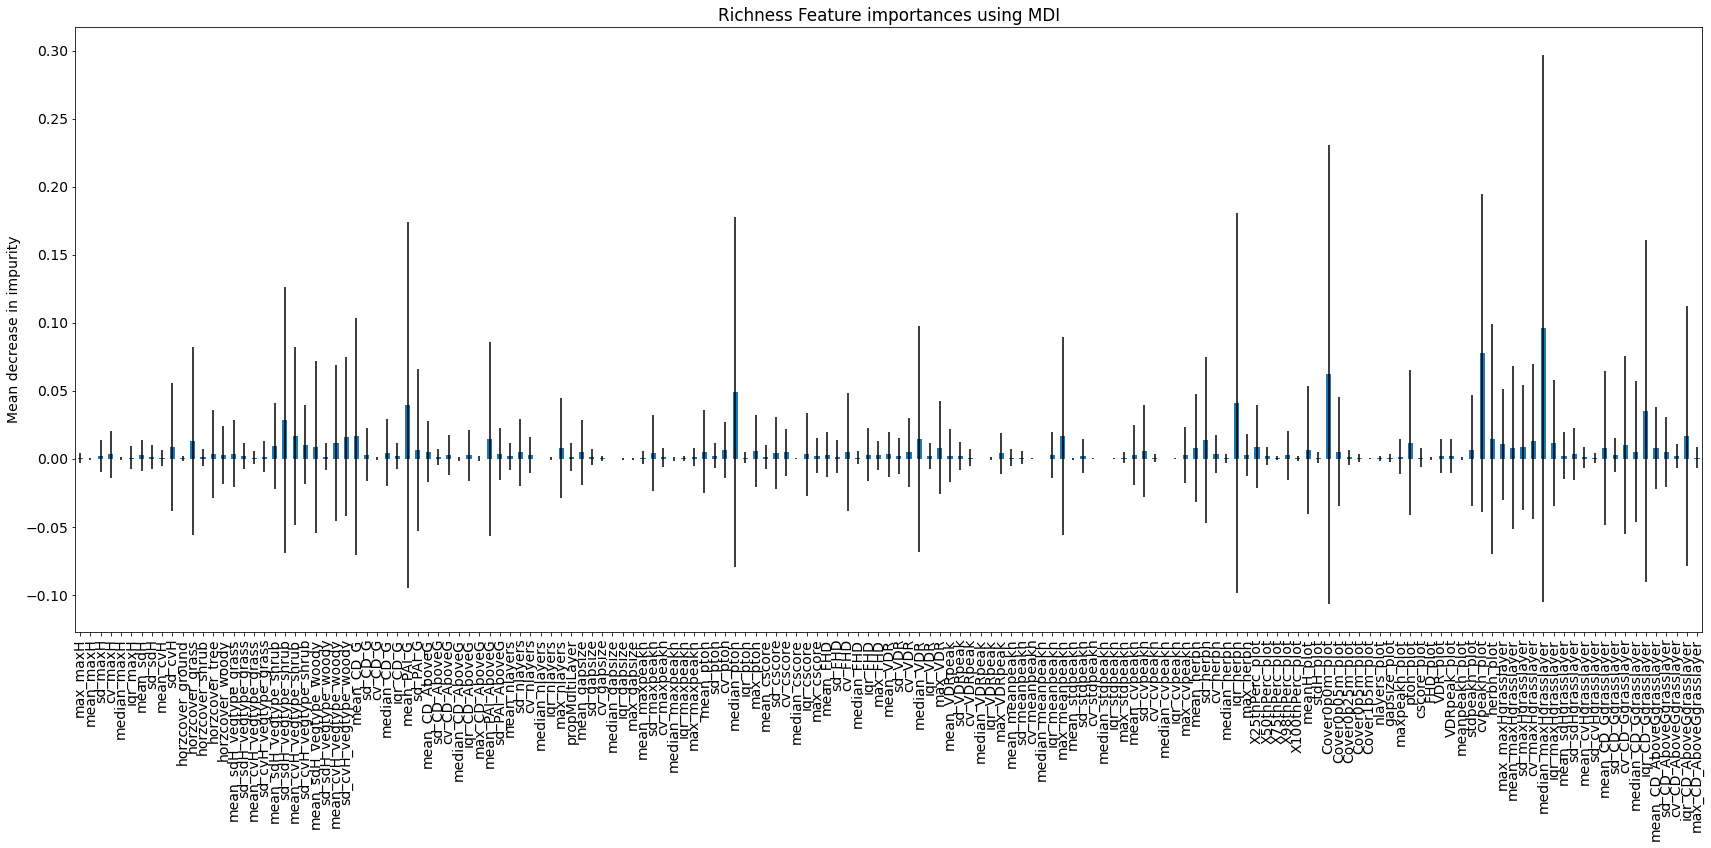

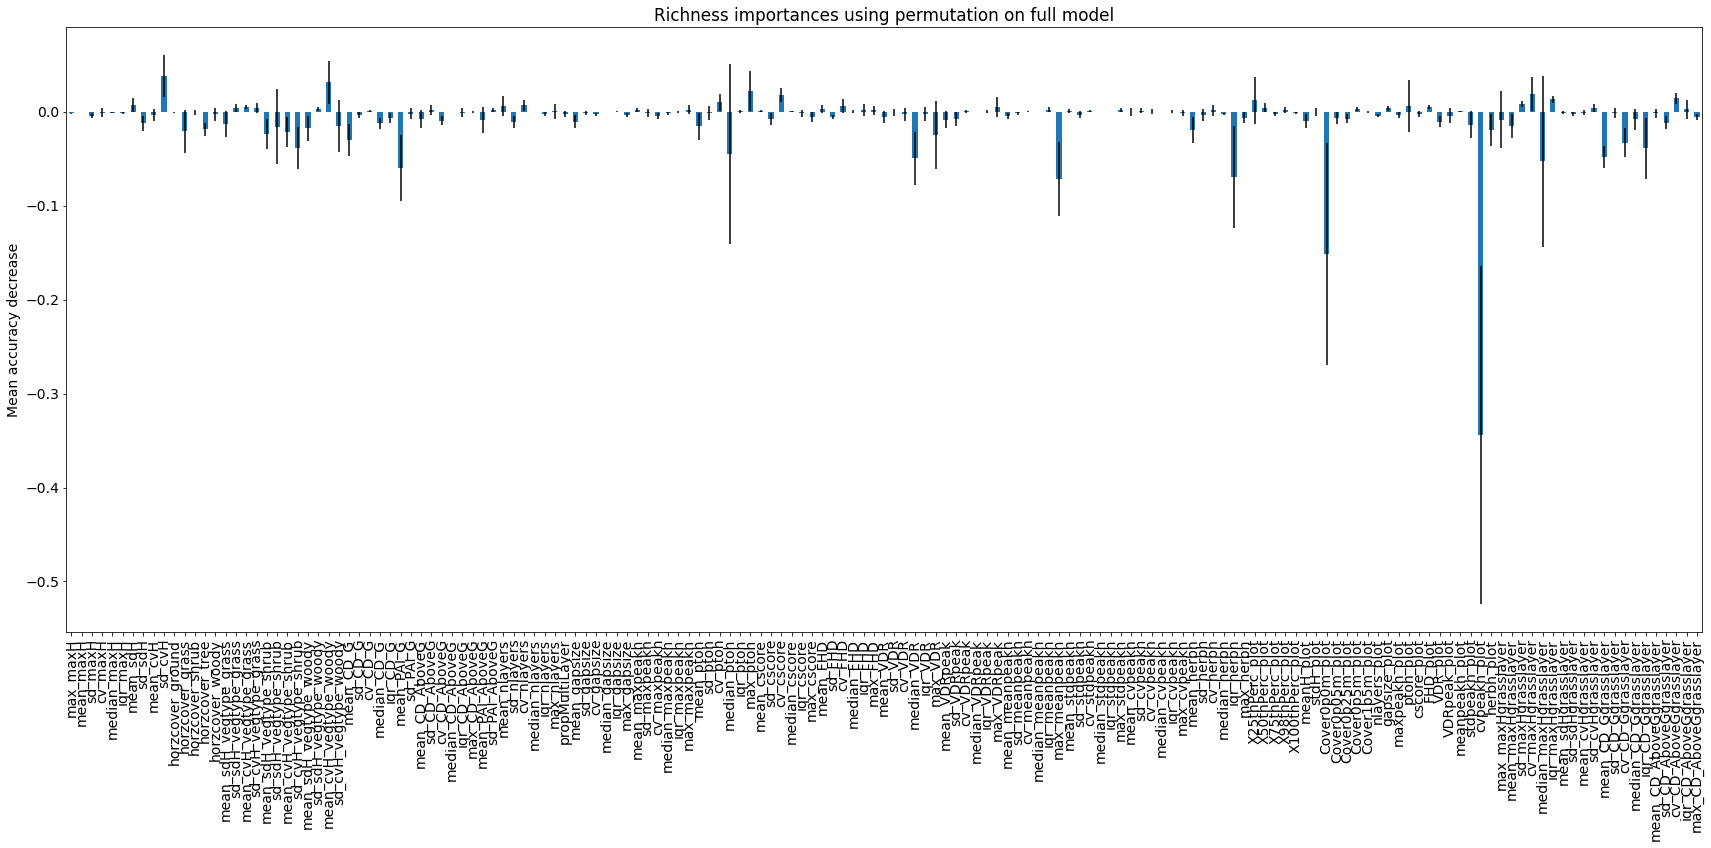




Richness MDI Top 6 X Vars:

	median_maxHgrasslayer
	cvpeakh_plot
	Cover0p0m_plot
	median_ptoh
	iqr_herbh
	mean_PAI_G
	iqr_CD_Ggrasslayer
	sd_sdH_vegtype_shrub
	max_meanpeakh
	mean_cvH_vegtype_shrub


Richness Permutation Top 6 X Vars:

	sd_cvH
	mean_cvH_vegtype_woody
	max_ptoh
	cv_maxHgrasslayer
	cv_cscore
	cv_CD_AboveGgrasslayer
	iqr_maxHgrasslayer
	X25thPerc_plot
	cv_ptoh
	sd_maxHgrasslayer





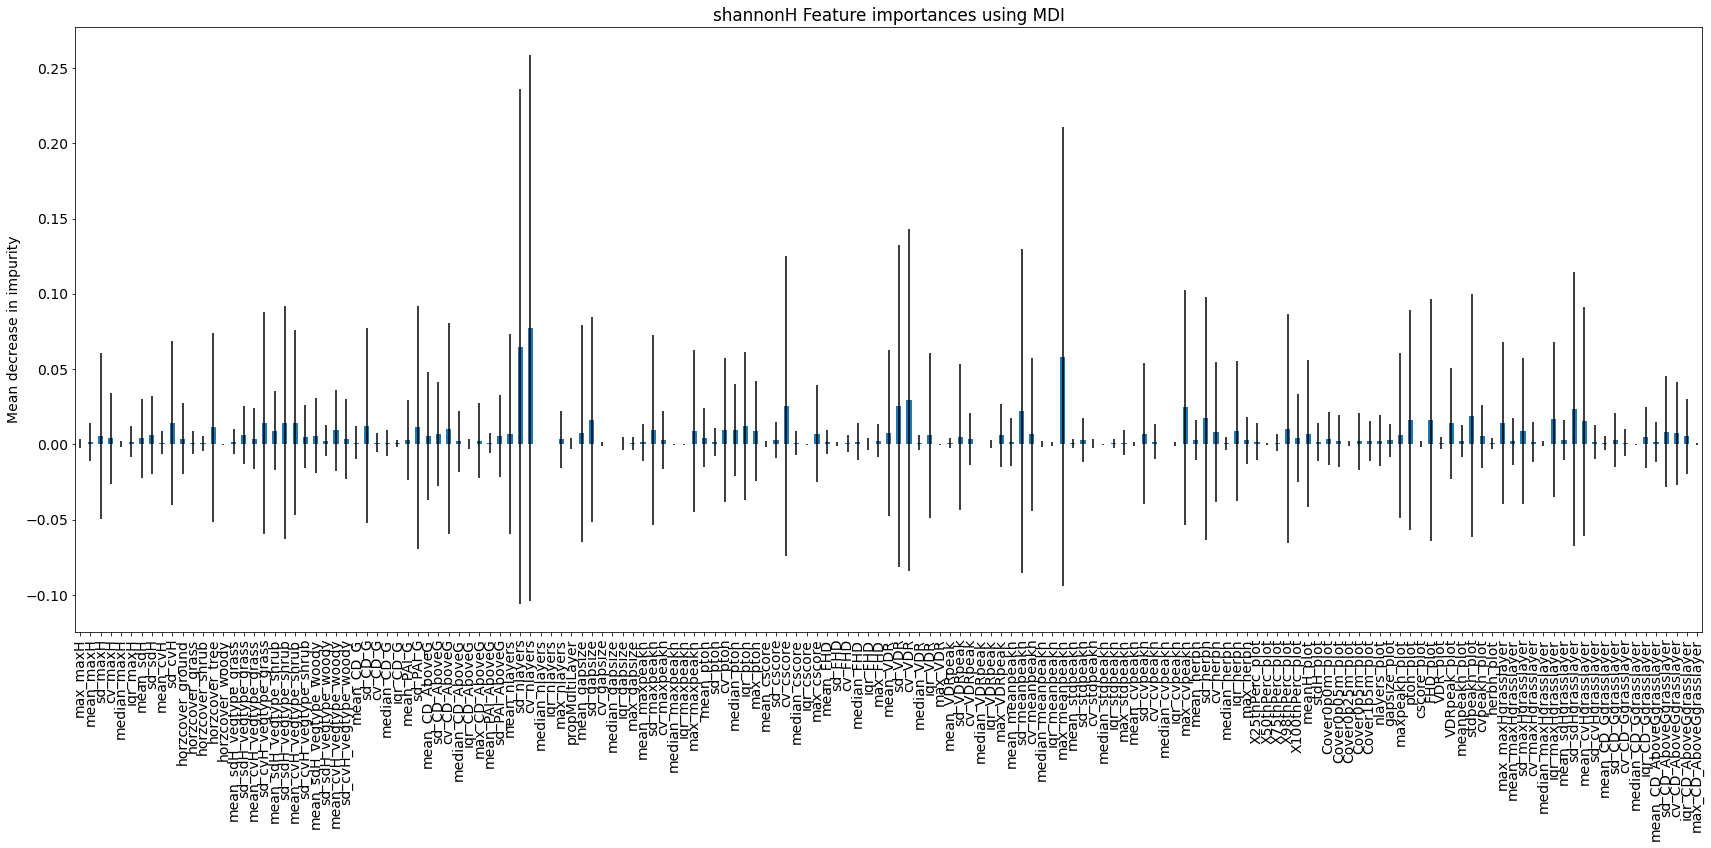

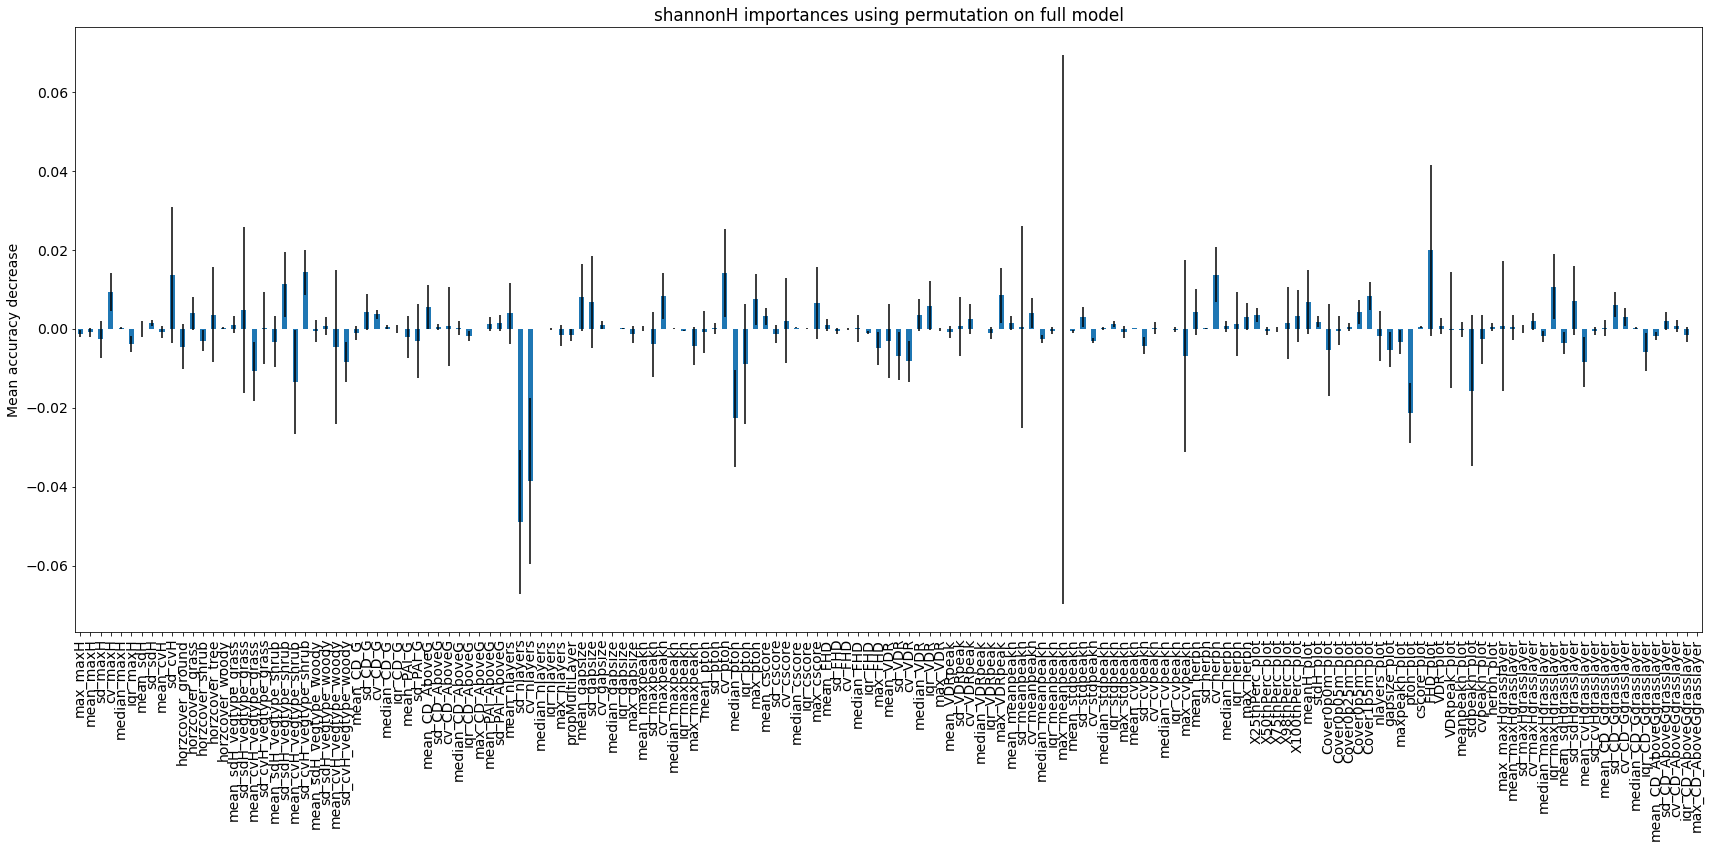




shannonH MDI Top 6 X Vars:

	cv_nlayers
	sd_nlayers
	max_meanpeakh
	cv_VDR
	sd_VDR
	cv_cscore
	max_cvpeakh
	sd_sdHgrasslayer
	sd_meanpeakh
	stdpeakh_plot


shannonH Permutation Top 6 X Vars:

	FHD_plot
	sd_cvH_vegtype_shrub
	cv_ptoh
	cv_herbh
	sd_cvH
	sd_sdH_vegtype_shrub
	iqr_maxHgrasslayer
	cv_maxH
	max_VDRpeak
	cv_maxpeakh





In [8]:
# For all soils
for feat in ['Abundance', 'Richness', 'shannonH']:
    mdi_top10, permute_top10, fig1, ax1, fig, ax = featureSelectRF(X=X, y=XY_scale[feat], feat=feat)

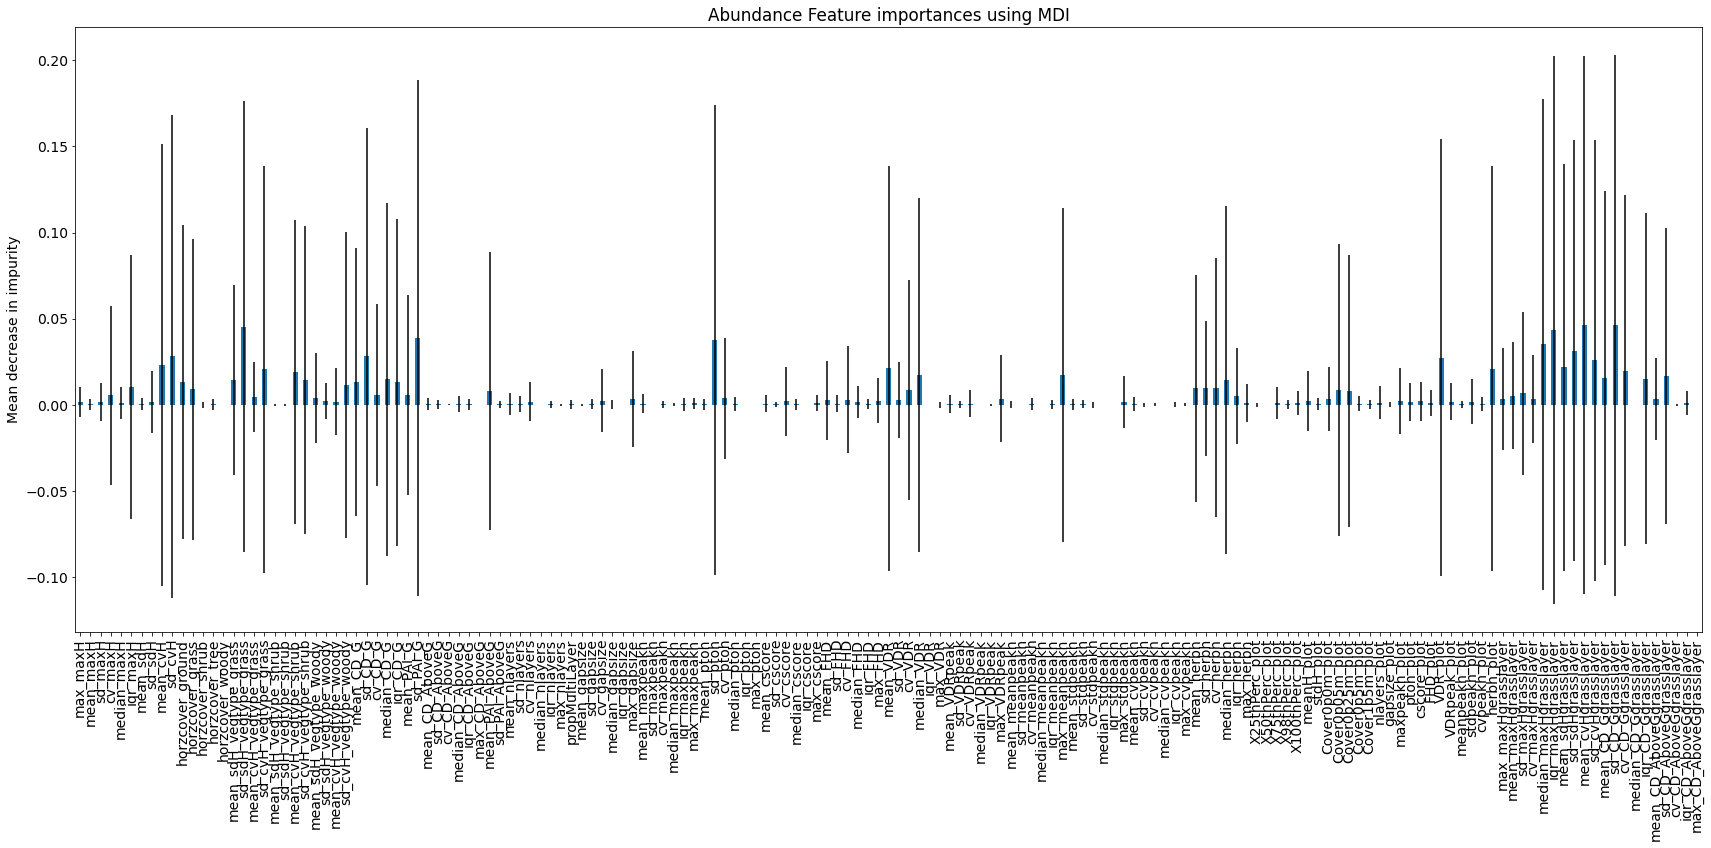

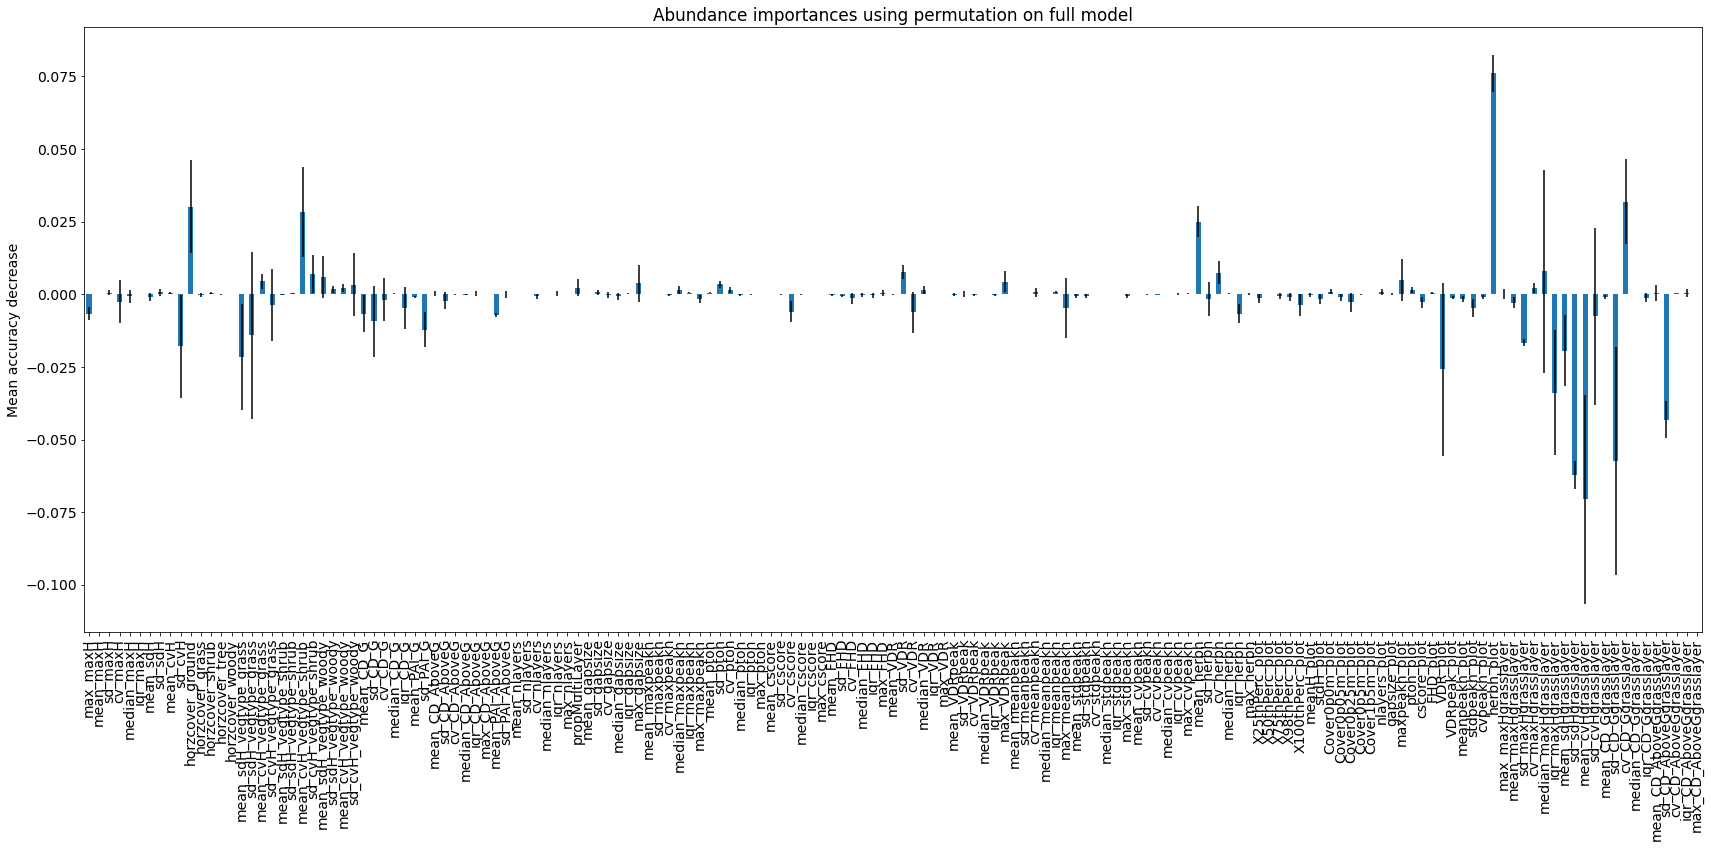




Abundance MDI Top 6 X Vars:

	mean_cvHgrasslayer
	sd_CD_Ggrasslayer
	sd_sdH_vegtype_grass
	iqr_maxHgrasslayer
	sd_PAI_G
	sd_ptoh
	median_maxHgrasslayer
	sd_sdHgrasslayer
	sd_CD_G
	sd_cvH


Abundance Permutation Top 6 X Vars:

	herbh_plot
	cv_CD_Ggrasslayer
	horzcover_ground
	mean_cvH_vegtype_shrub
	mean_herbh
	median_maxHgrasslayer
	sd_VDR
	cv_herbh
	sd_cvH_vegtype_shrub
	mean_sdH_vegtype_woody





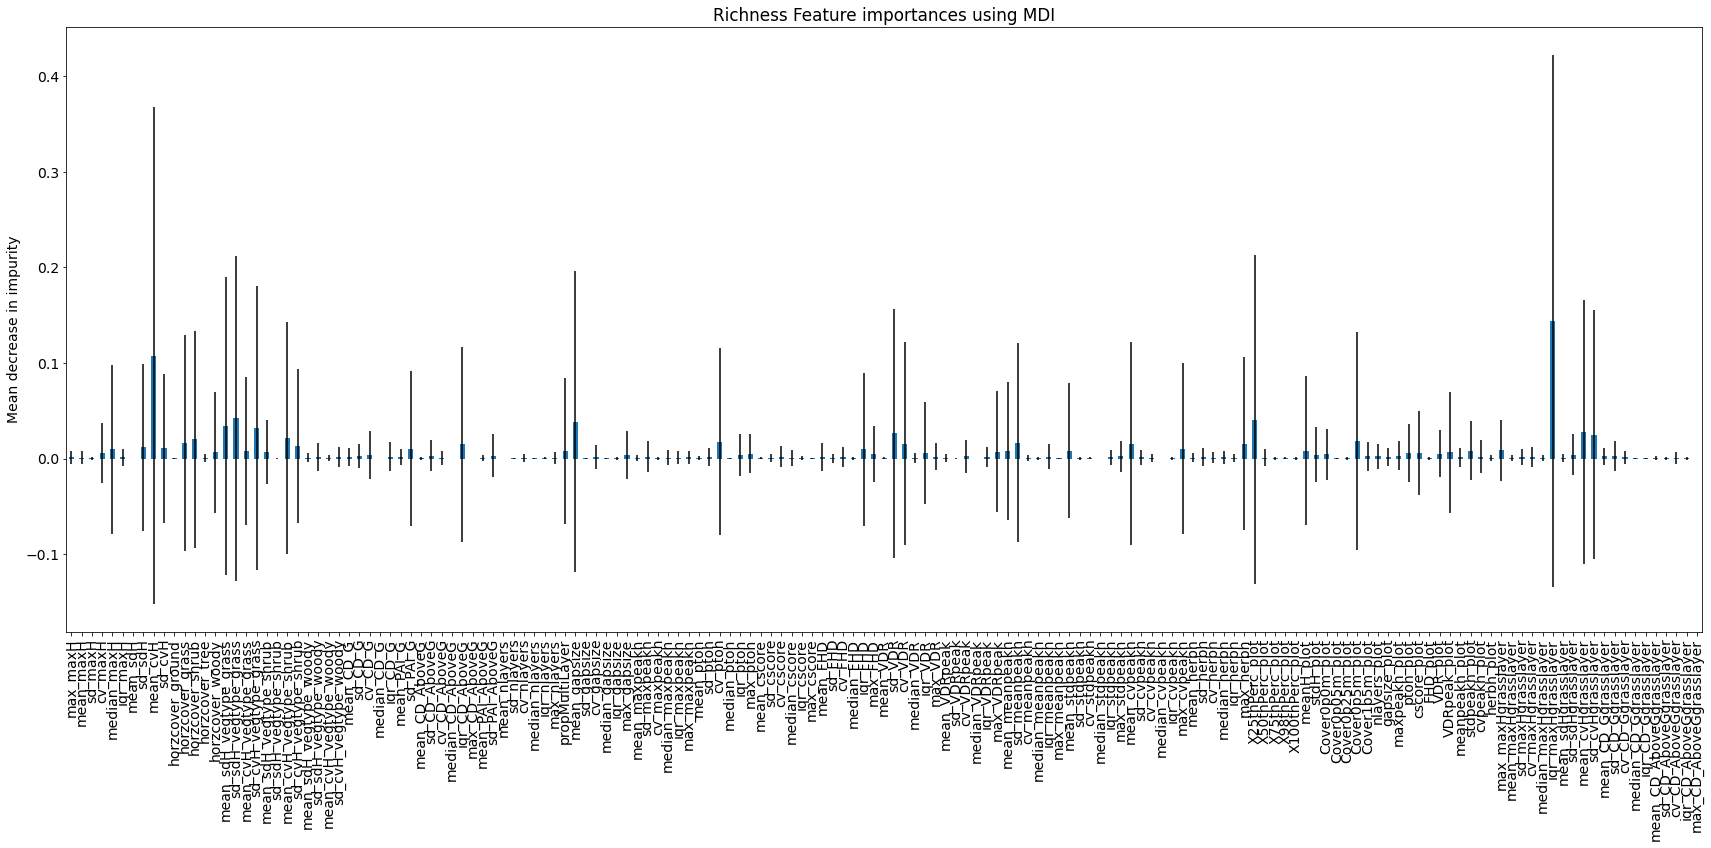

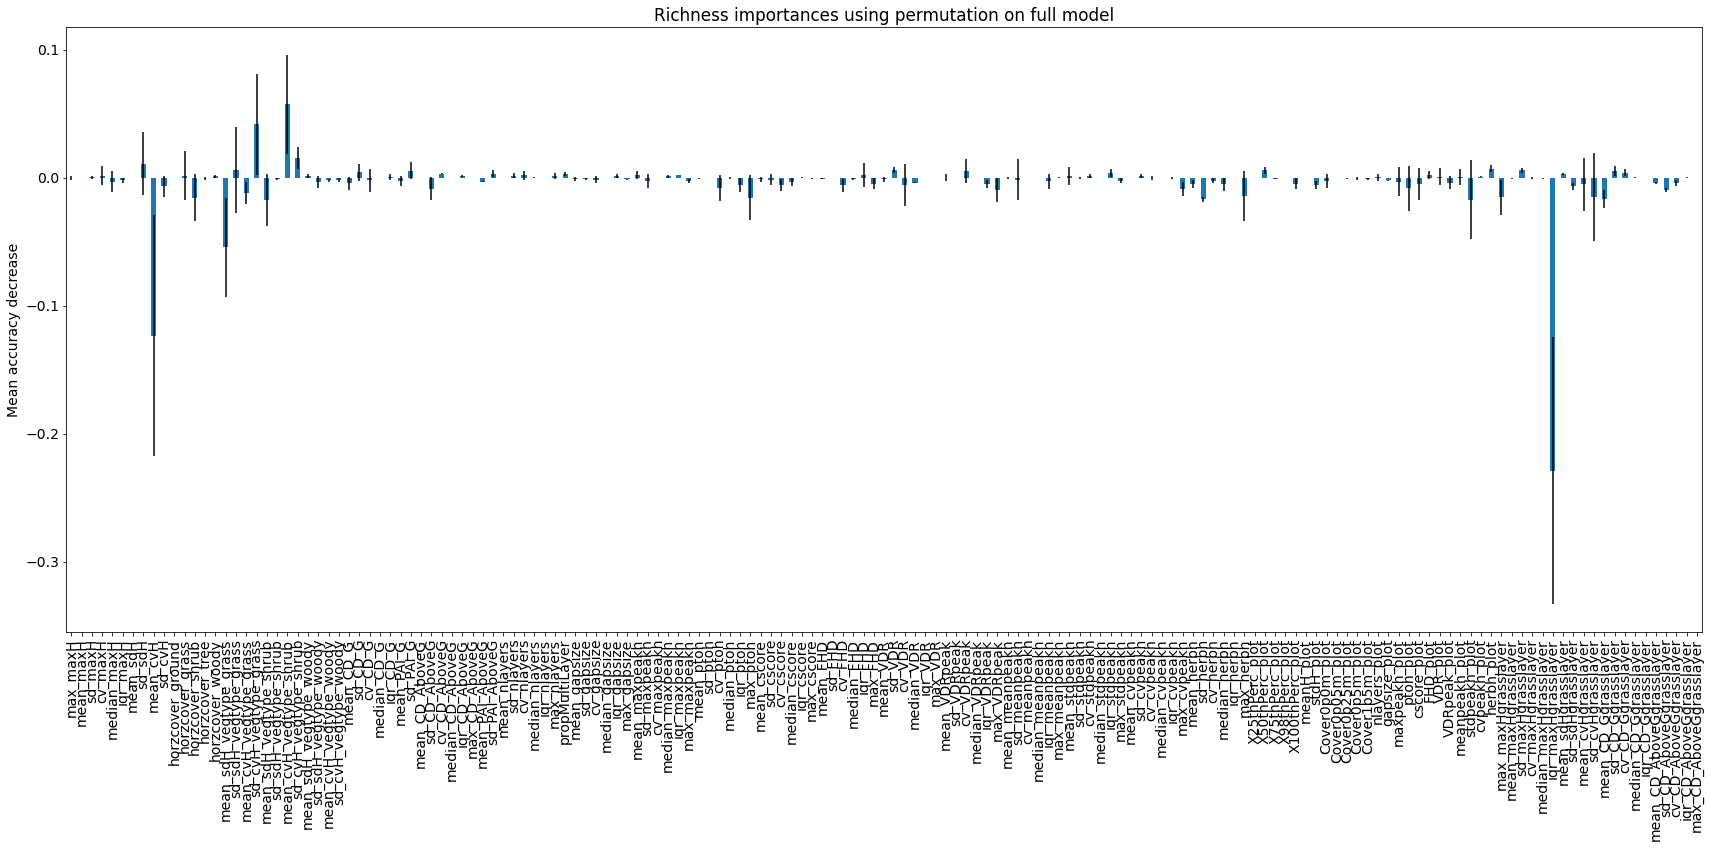




Richness MDI Top 6 X Vars:

	iqr_maxHgrasslayer
	mean_cvH
	sd_sdH_vegtype_grass
	X25thPerc_plot
	mean_gapsize
	mean_sdH_vegtype_grass
	sd_cvH_vegtype_grass
	mean_cvHgrasslayer
	sd_VDR
	sd_cvHgrasslayer


Richness Permutation Top 6 X Vars:

	mean_cvH_vegtype_shrub
	sd_cvH_vegtype_grass
	sd_cvH_vegtype_shrub
	sd_sdH
	herbh_plot
	sd_maxHgrasslayer
	sd_sdH_vegtype_grass
	sd_VDR
	X50thPerc_plot
	sd_PAI_G





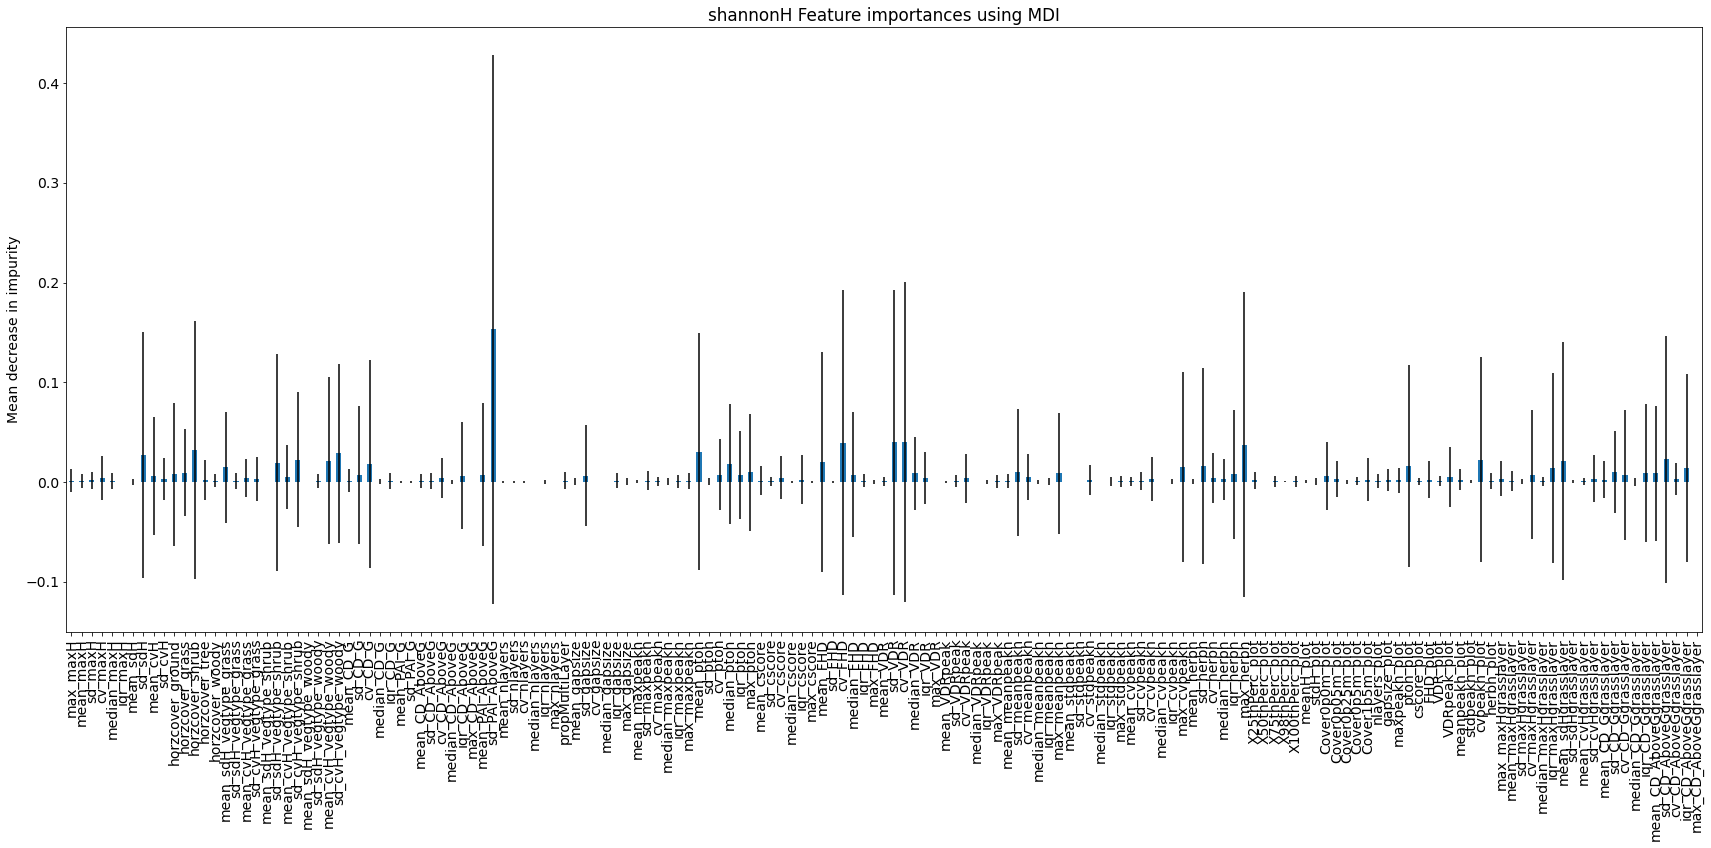

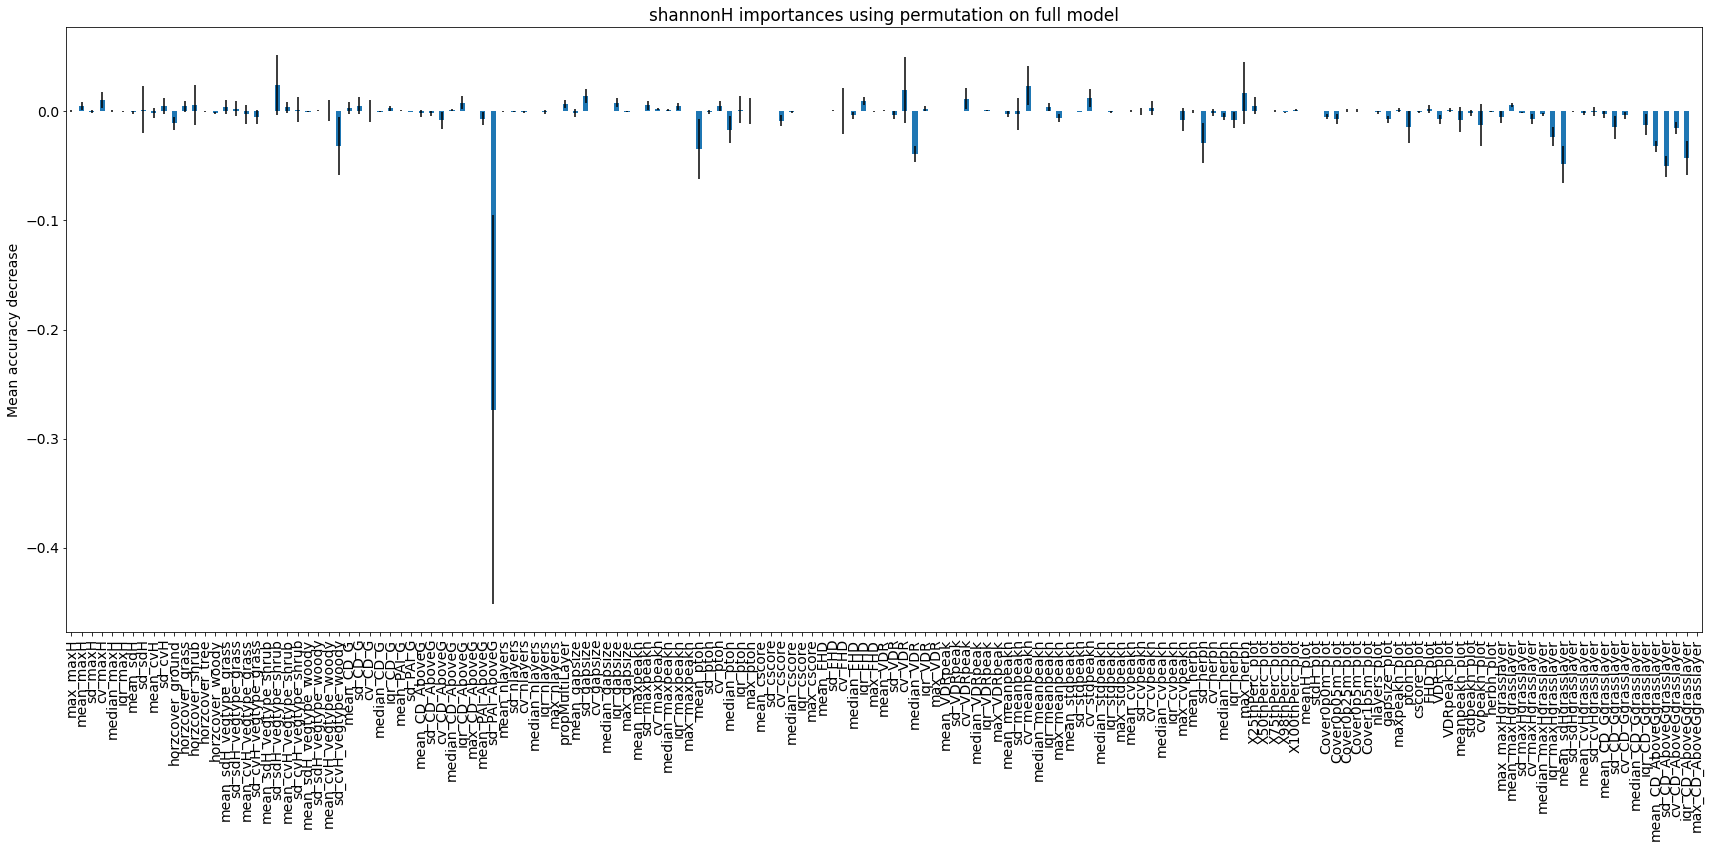




shannonH MDI Top 6 X Vars:

	sd_PAI_AboveG
	cv_VDR
	sd_VDR
	cv_FHD
	max_herbh
	horzcover_shrub
	mean_ptoh
	sd_cvH_vegtype_woody
	sd_sdH
	sd_CD_AboveGgrasslayer


shannonH Permutation Top 6 X Vars:

	sd_sdH_vegtype_shrub
	cv_meanpeakh
	cv_VDR
	max_herbh
	sd_gapsize
	cv_stdpeakh
	cv_VDRpeak
	cv_maxH
	iqr_FHD
	iqr_gapsize





In [9]:
# For Red Soils Only
redidx = XY_scale.Soil=='Red'
for feat in ['Abundance', 'Richness', 'shannonH']:
    mdi_top10, permute_top10, fig1, ax1, fig, ax = featureSelectRF(X=X.loc[redidx], y=XY_scale[feat][redidx], feat=feat)

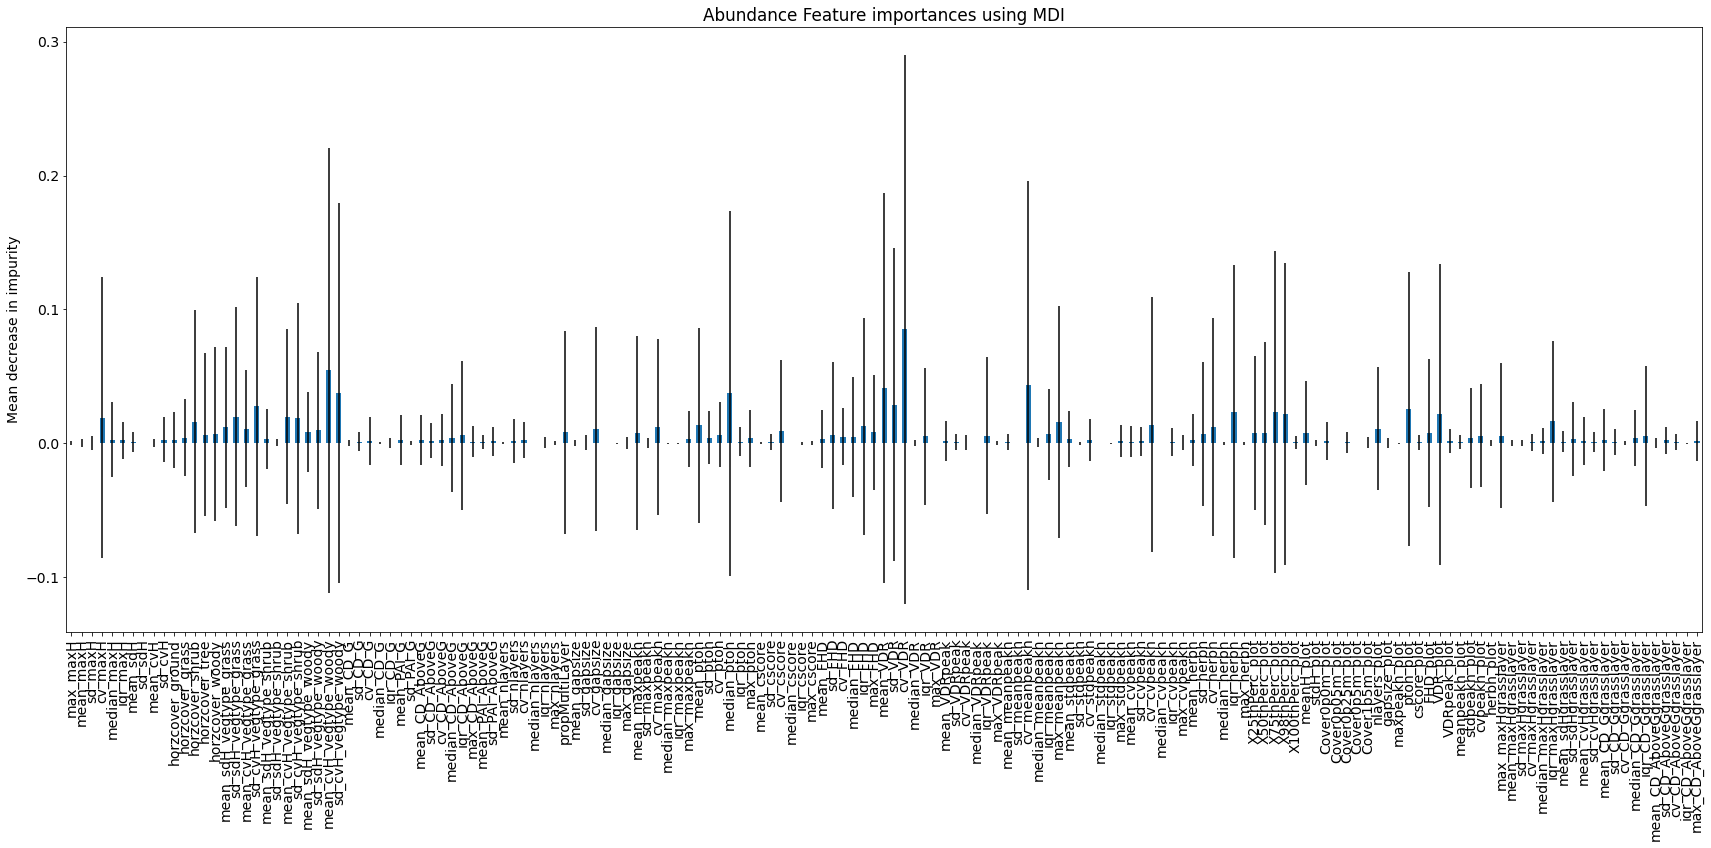

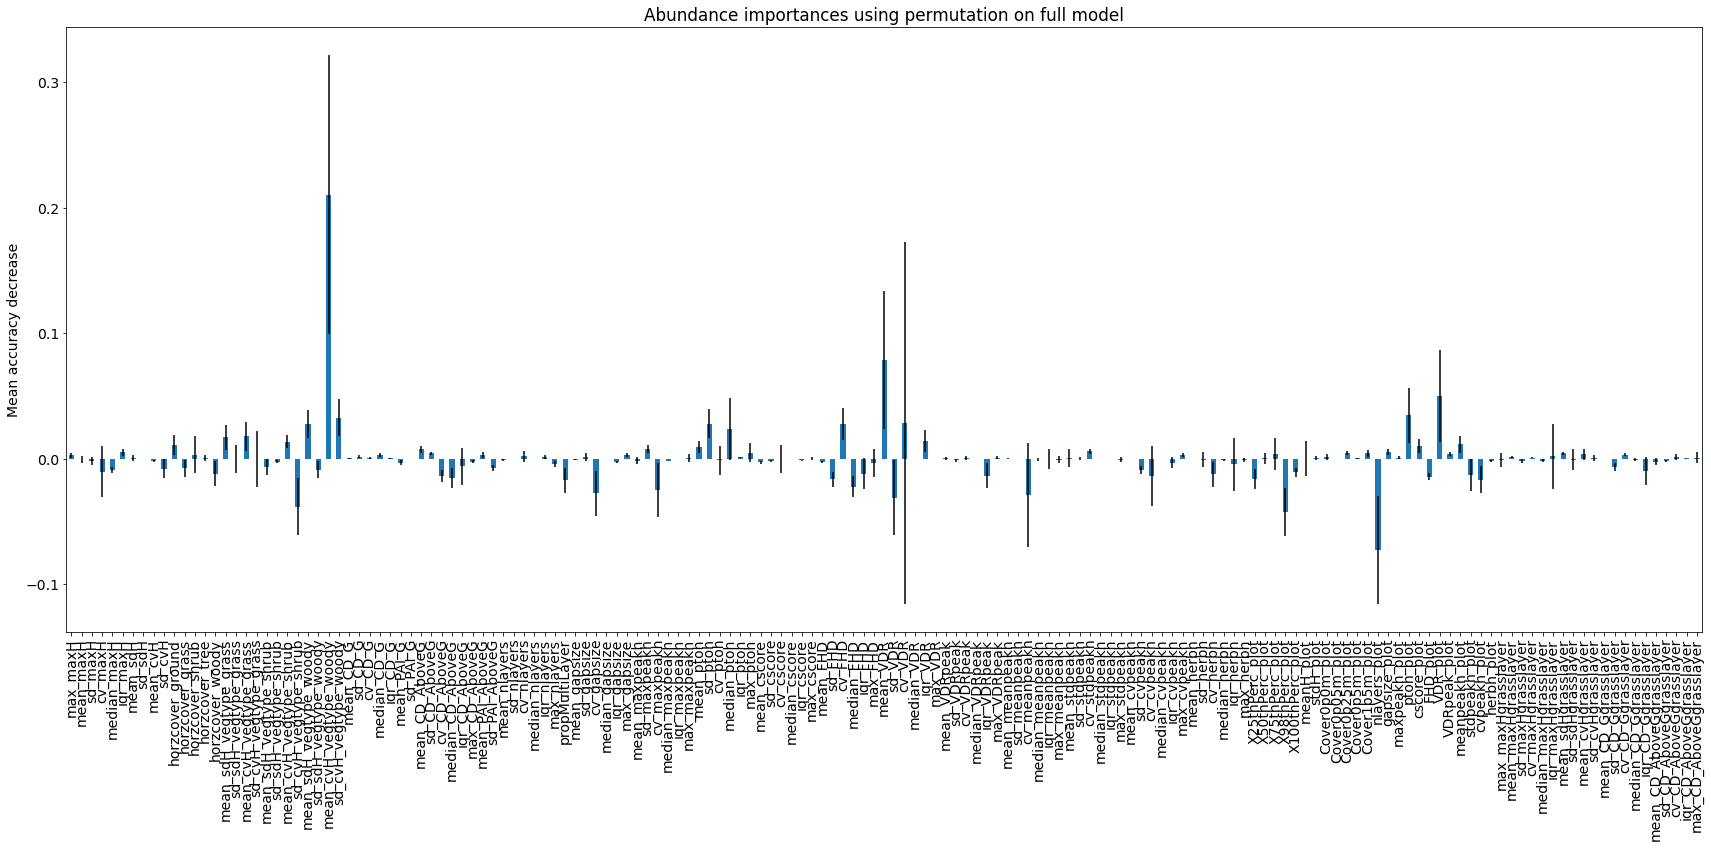




Abundance MDI Top 6 X Vars:

	cv_VDR
	mean_cvH_vegtype_woody
	cv_meanpeakh
	mean_VDR
	median_ptoh
	sd_cvH_vegtype_woody
	sd_VDR
	sd_cvH_vegtype_grass
	ptoh_plot
	iqr_herbh


Abundance Permutation Top 6 X Vars:

	mean_cvH_vegtype_woody
	mean_VDR
	VDR_plot
	ptoh_plot
	sd_cvH_vegtype_woody
	cv_VDR
	sd_ptoh
	mean_sdH_vegtype_woody
	cv_FHD
	median_ptoh





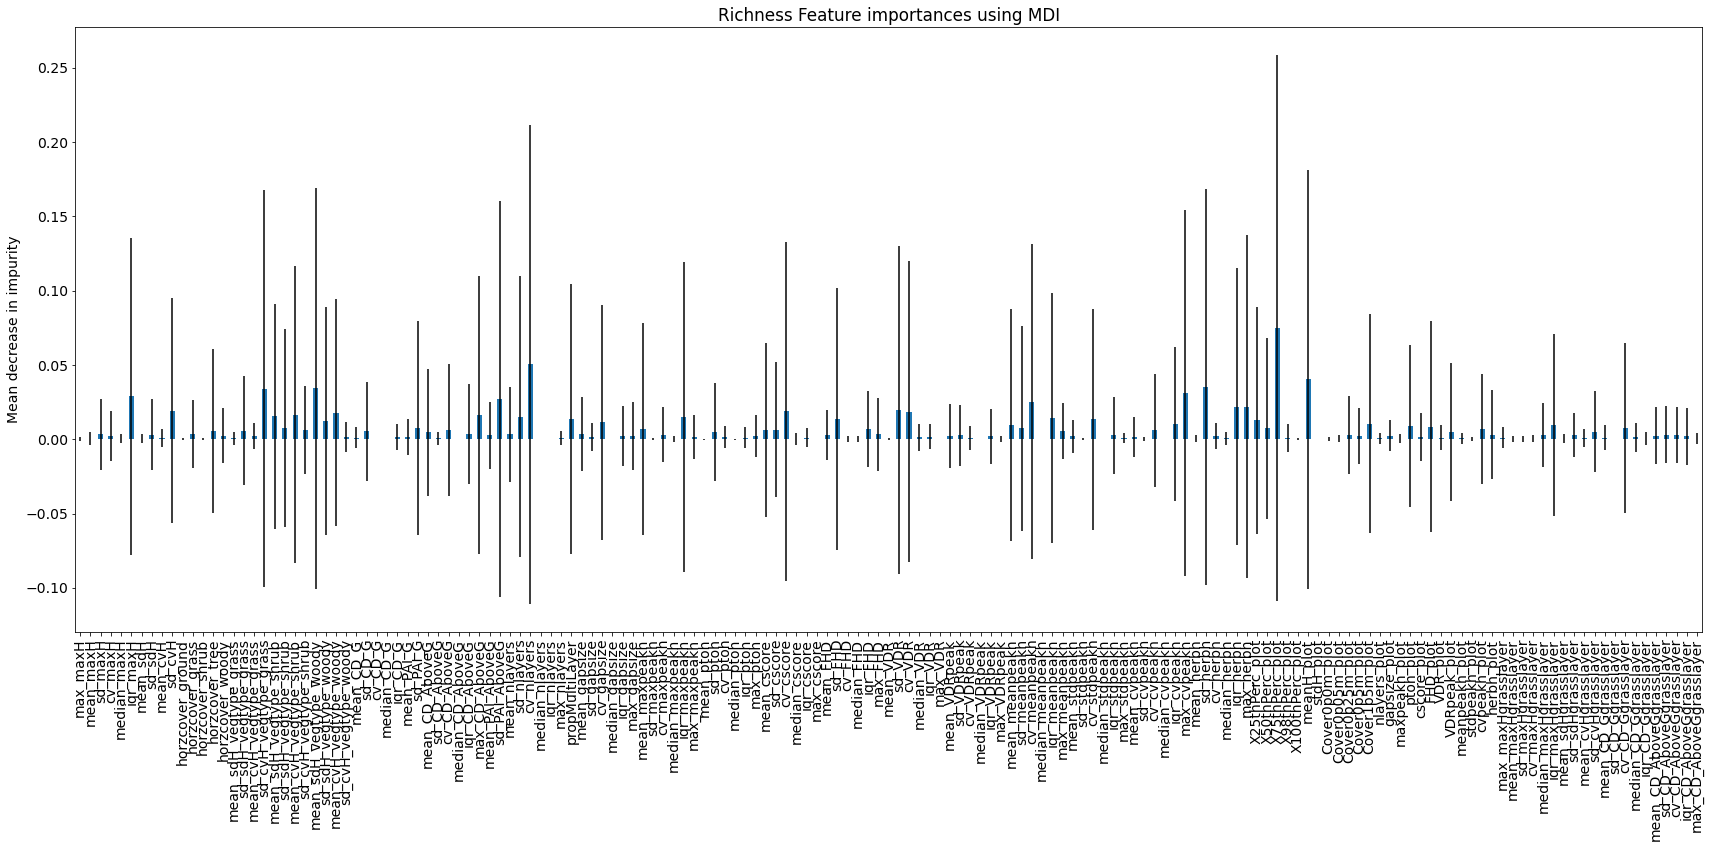

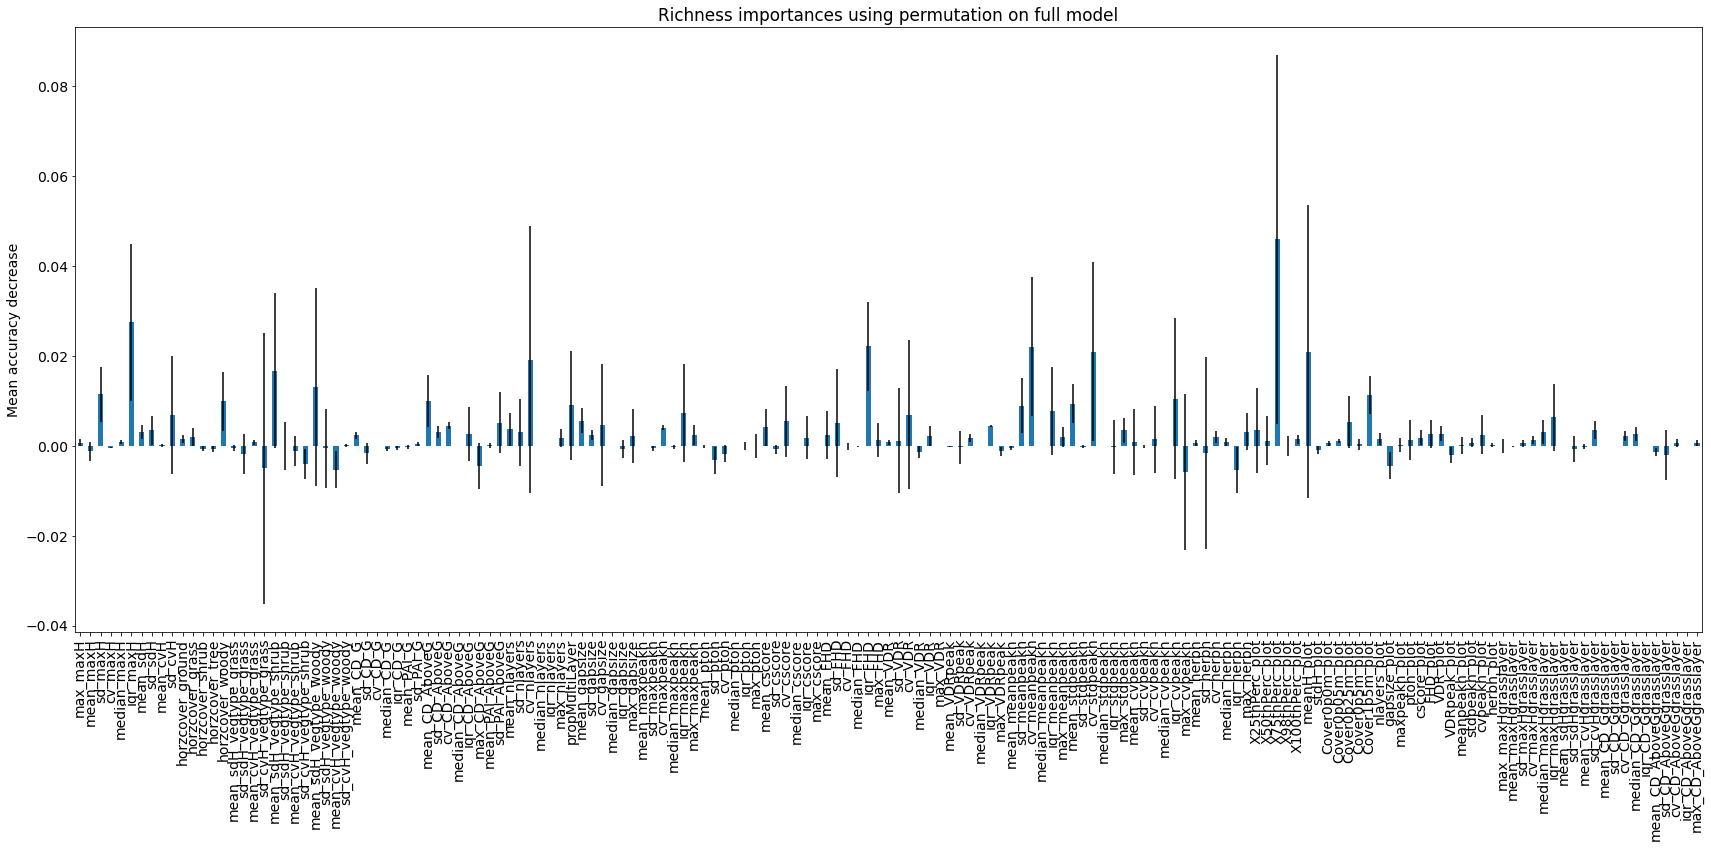




Richness MDI Top 6 X Vars:

	X75thPerc_plot
	cv_nlayers
	meanH_plot
	sd_herbh
	mean_sdH_vegtype_woody
	sd_cvH_vegtype_grass
	max_cvpeakh
	iqr_maxH
	sd_PAI_AboveG
	cv_meanpeakh


Richness Permutation Top 6 X Vars:

	X75thPerc_plot
	iqr_maxH
	iqr_FHD
	cv_meanpeakh
	meanH_plot
	cv_stdpeakh
	cv_nlayers
	mean_sdH_vegtype_shrub
	mean_sdH_vegtype_woody
	sd_maxH





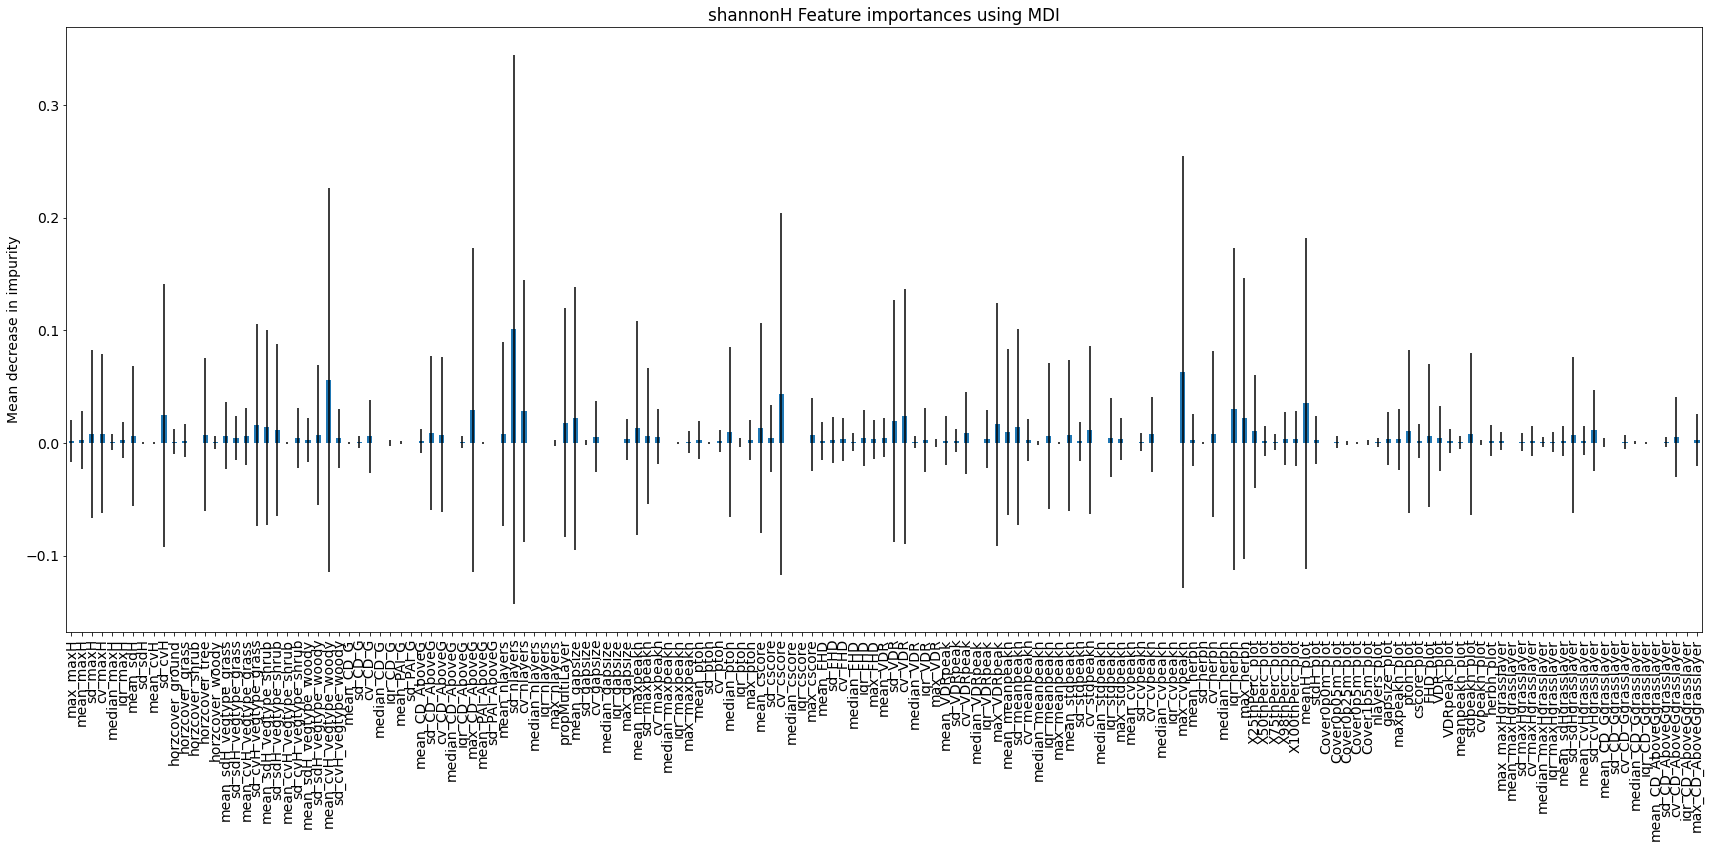

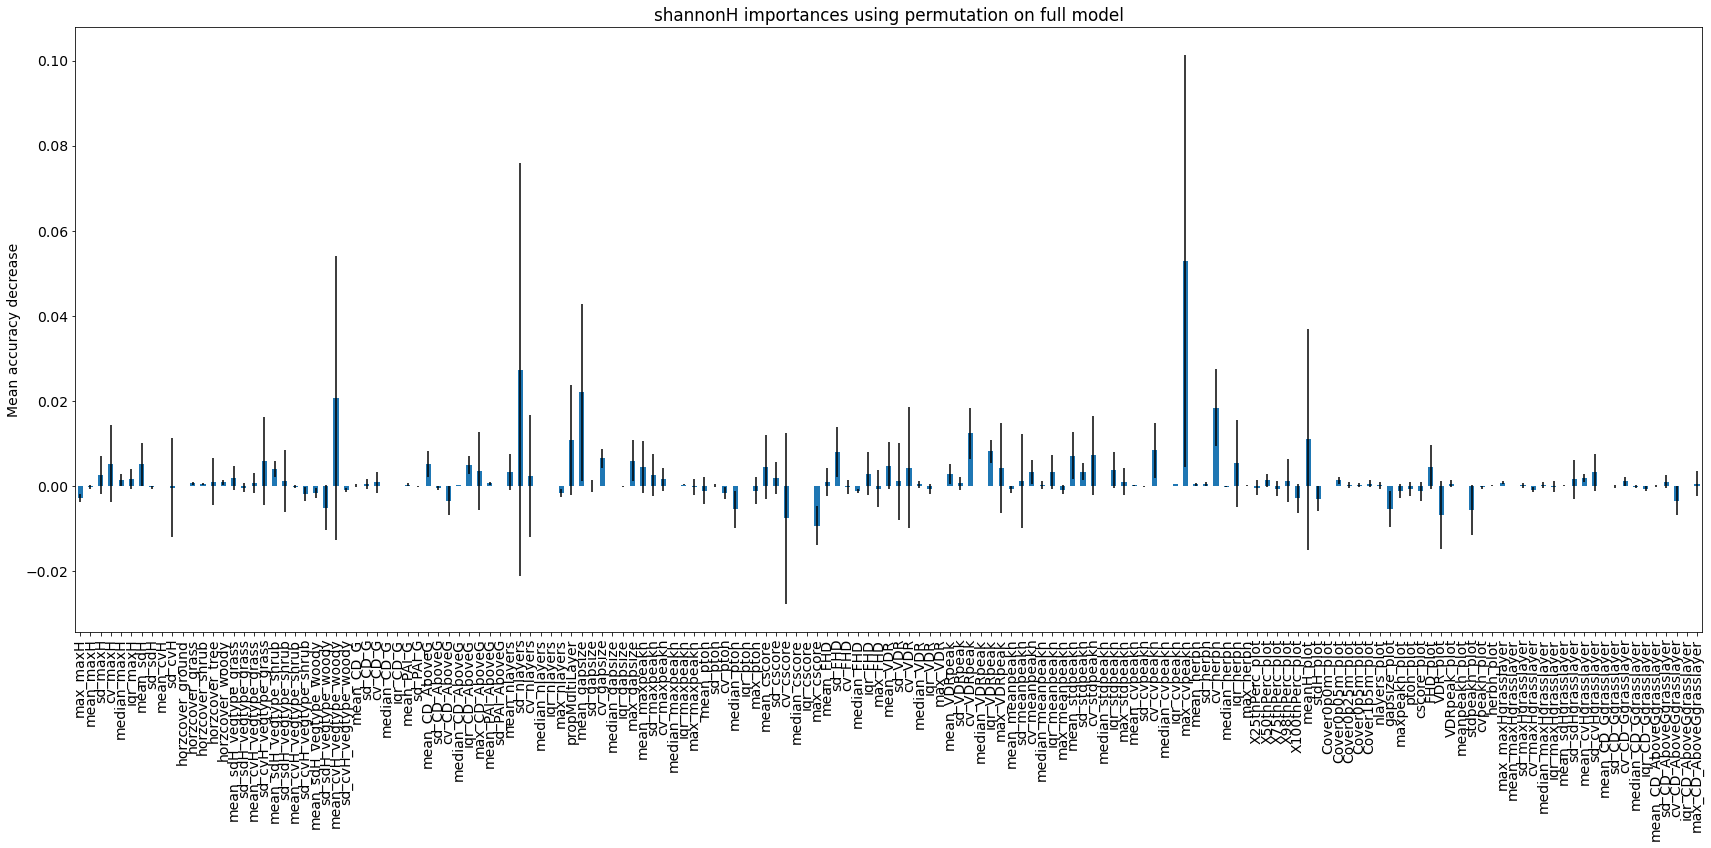




shannonH MDI Top 6 X Vars:

	sd_nlayers
	max_cvpeakh
	mean_cvH_vegtype_woody
	cv_cscore
	meanH_plot
	iqr_herbh
	max_CD_AboveG
	cv_nlayers
	sd_cvH
	cv_VDR


shannonH Permutation Top 6 X Vars:

	max_cvpeakh
	sd_nlayers
	mean_gapsize
	mean_cvH_vegtype_woody
	cv_herbh
	cv_VDRpeak
	meanH_plot
	propMultiLayer
	cv_cvpeakh
	iqr_VDRpeak





In [10]:
# For Black Soils Only
blackidx = XY_scale.Soil=='Black'
for feat in ['Abundance', 'Richness', 'shannonH']:
    mdi_top10, permute_top10, fig1, ax1, fig, ax = featureSelectRF(X=X.loc[blackidx],
                                                                   y=XY_scale[feat][blackidx],
                                                                   feat=feat)

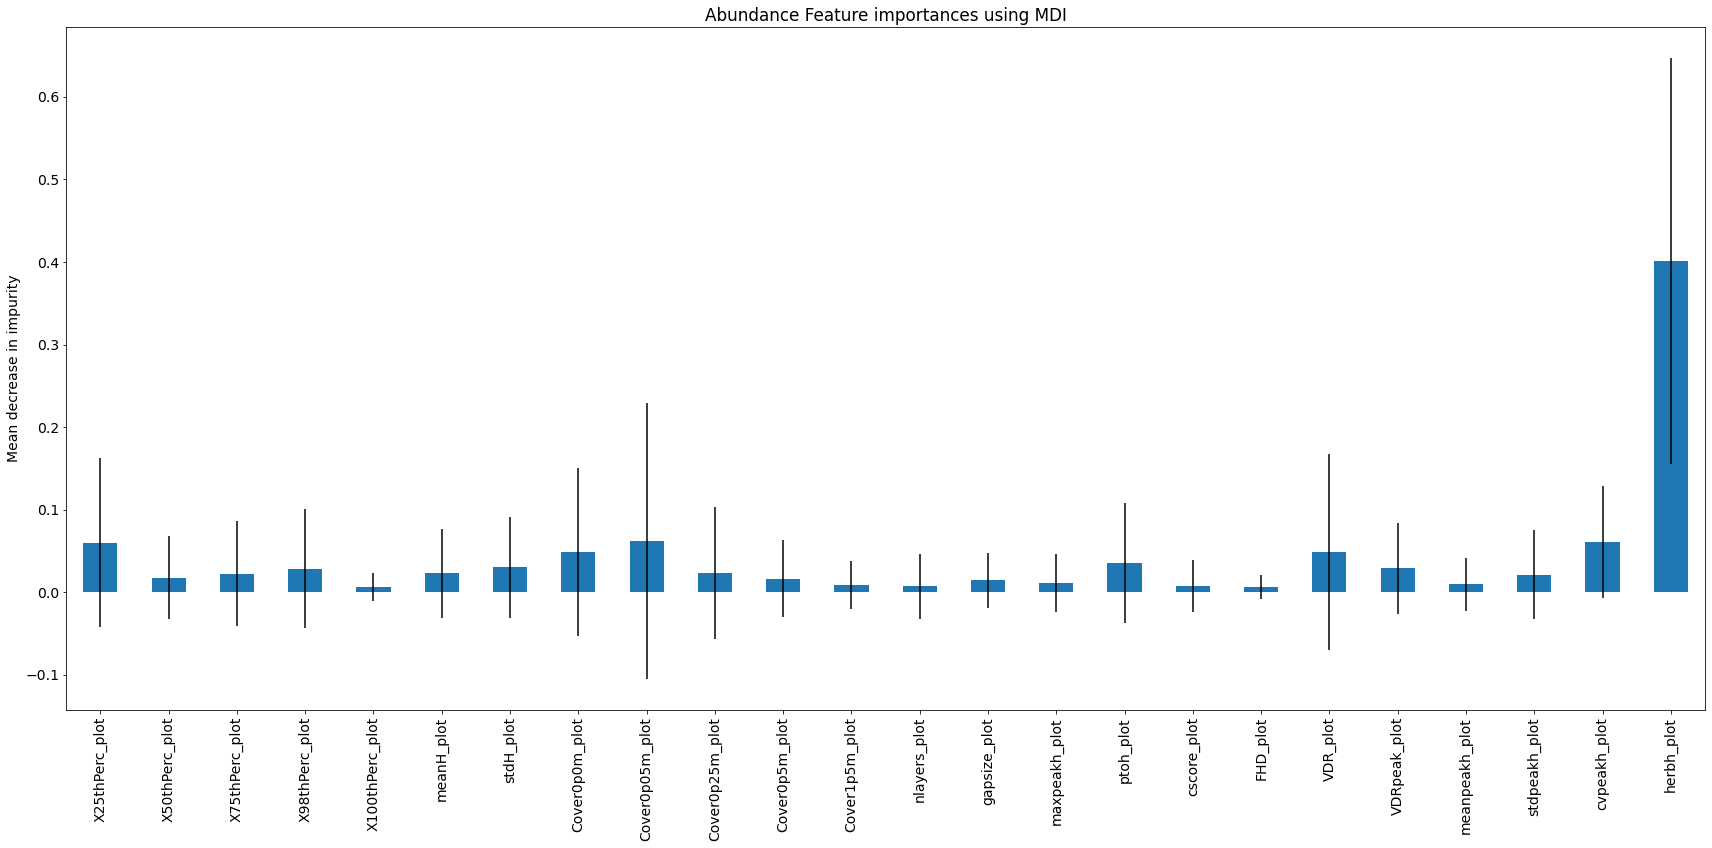

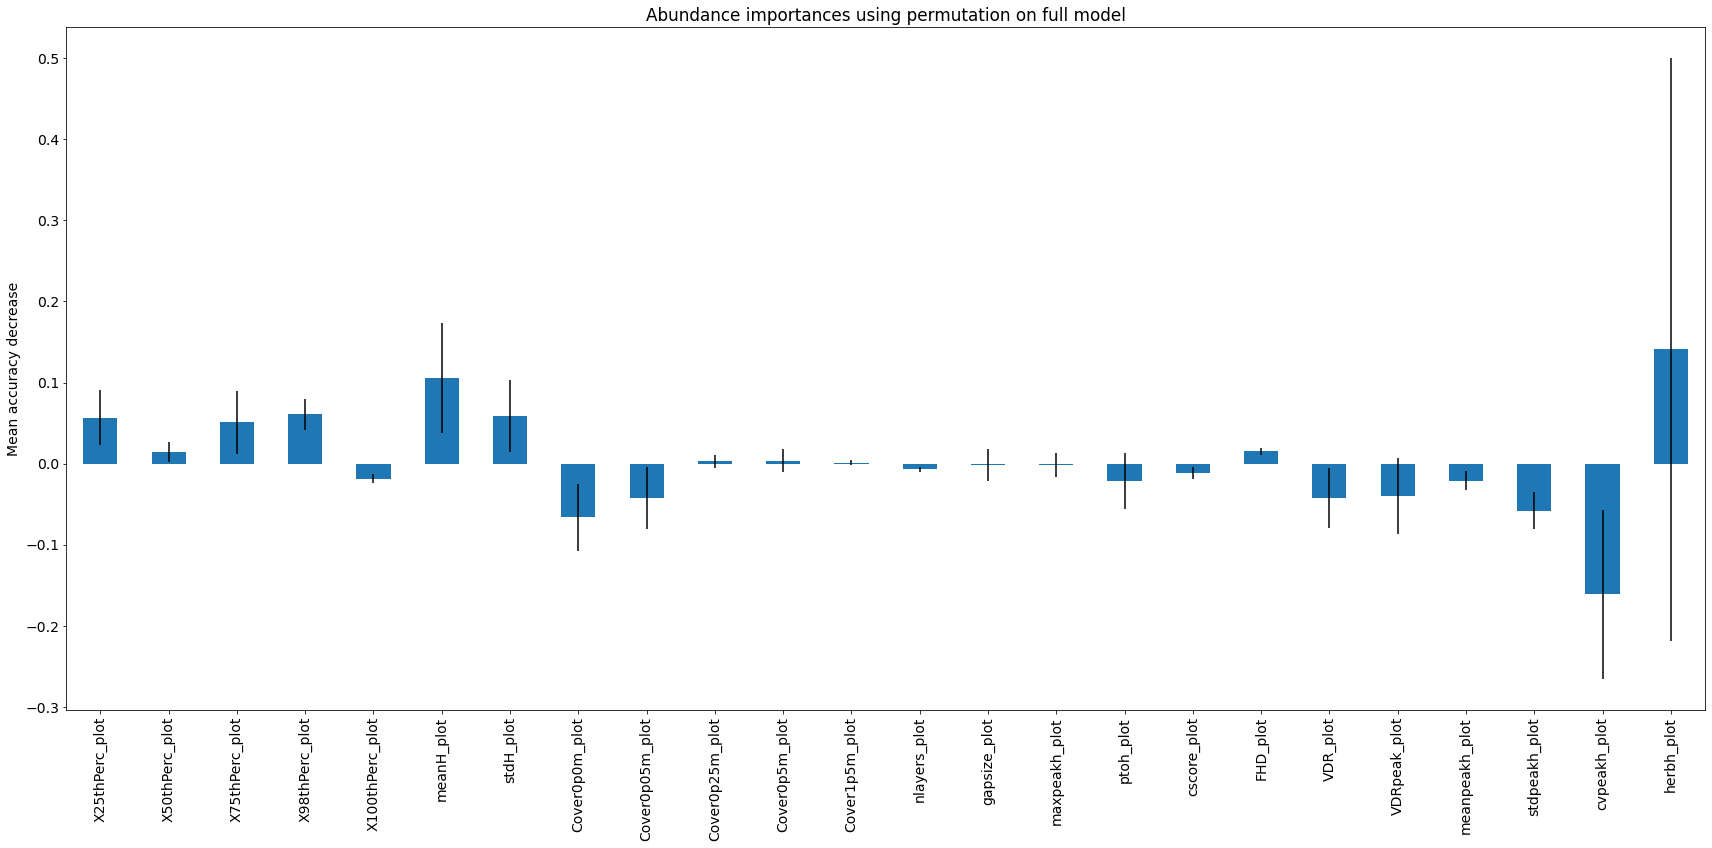




Abundance MDI Top 6 X Vars:

	herbh_plot
	Cover0p05m_plot
	cvpeakh_plot
	X25thPerc_plot
	Cover0p0m_plot
	VDR_plot
	ptoh_plot
	stdH_plot
	VDRpeak_plot
	X98thPerc_plot


Abundance Permutation Top 6 X Vars:

	herbh_plot
	meanH_plot
	X98thPerc_plot
	stdH_plot
	X25thPerc_plot
	X75thPerc_plot
	FHD_plot
	X50thPerc_plot
	Cover0p5m_plot
	Cover0p25m_plot





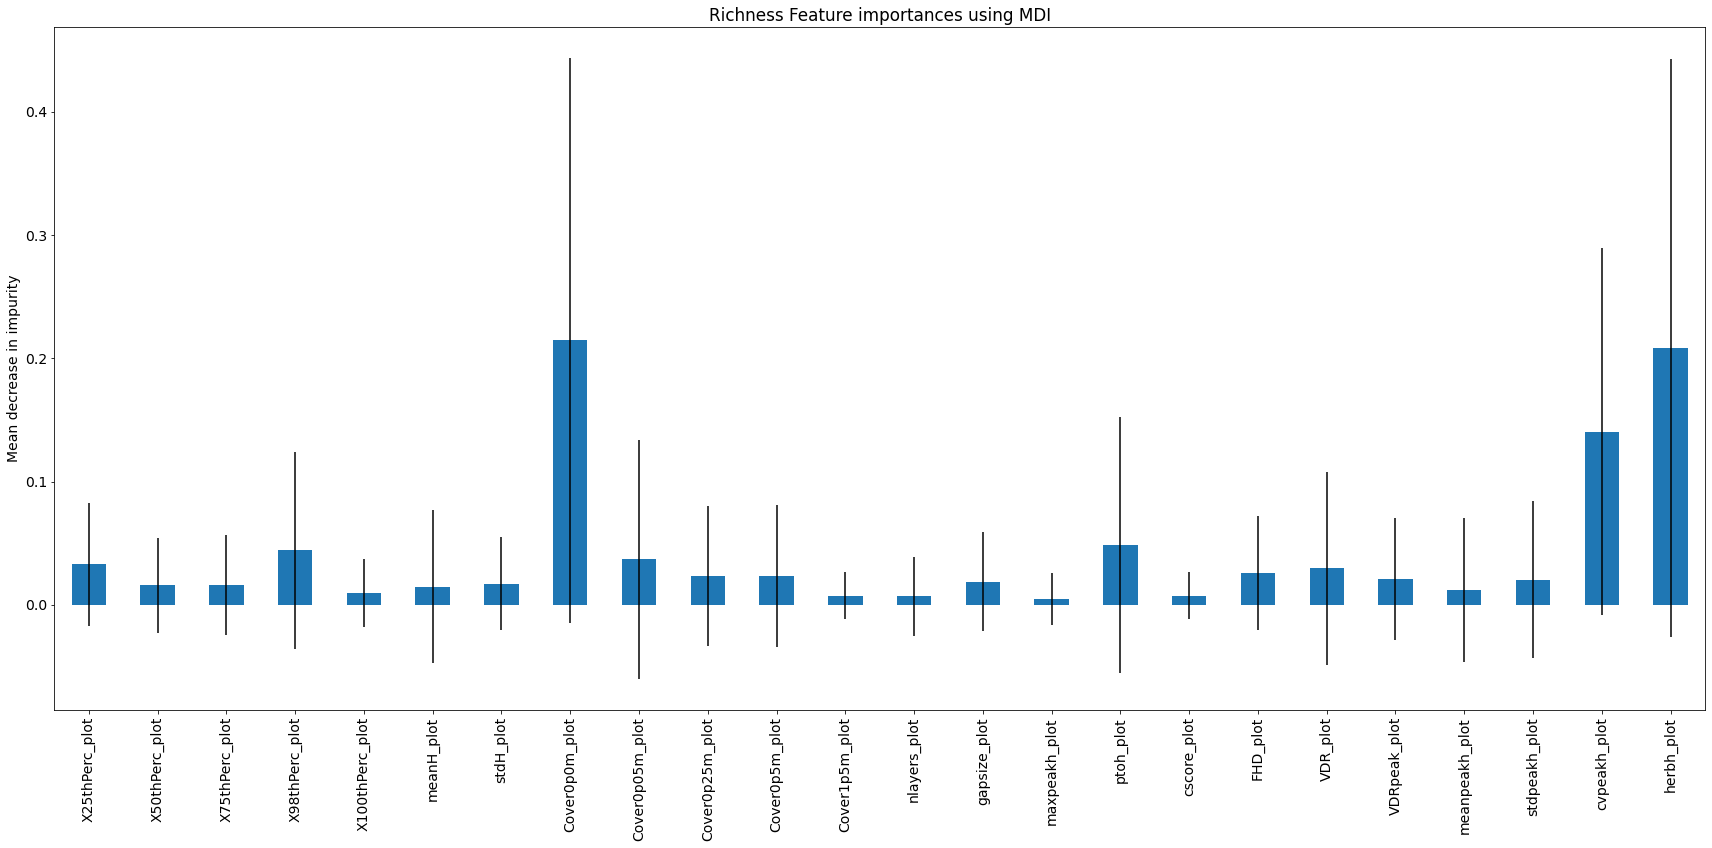

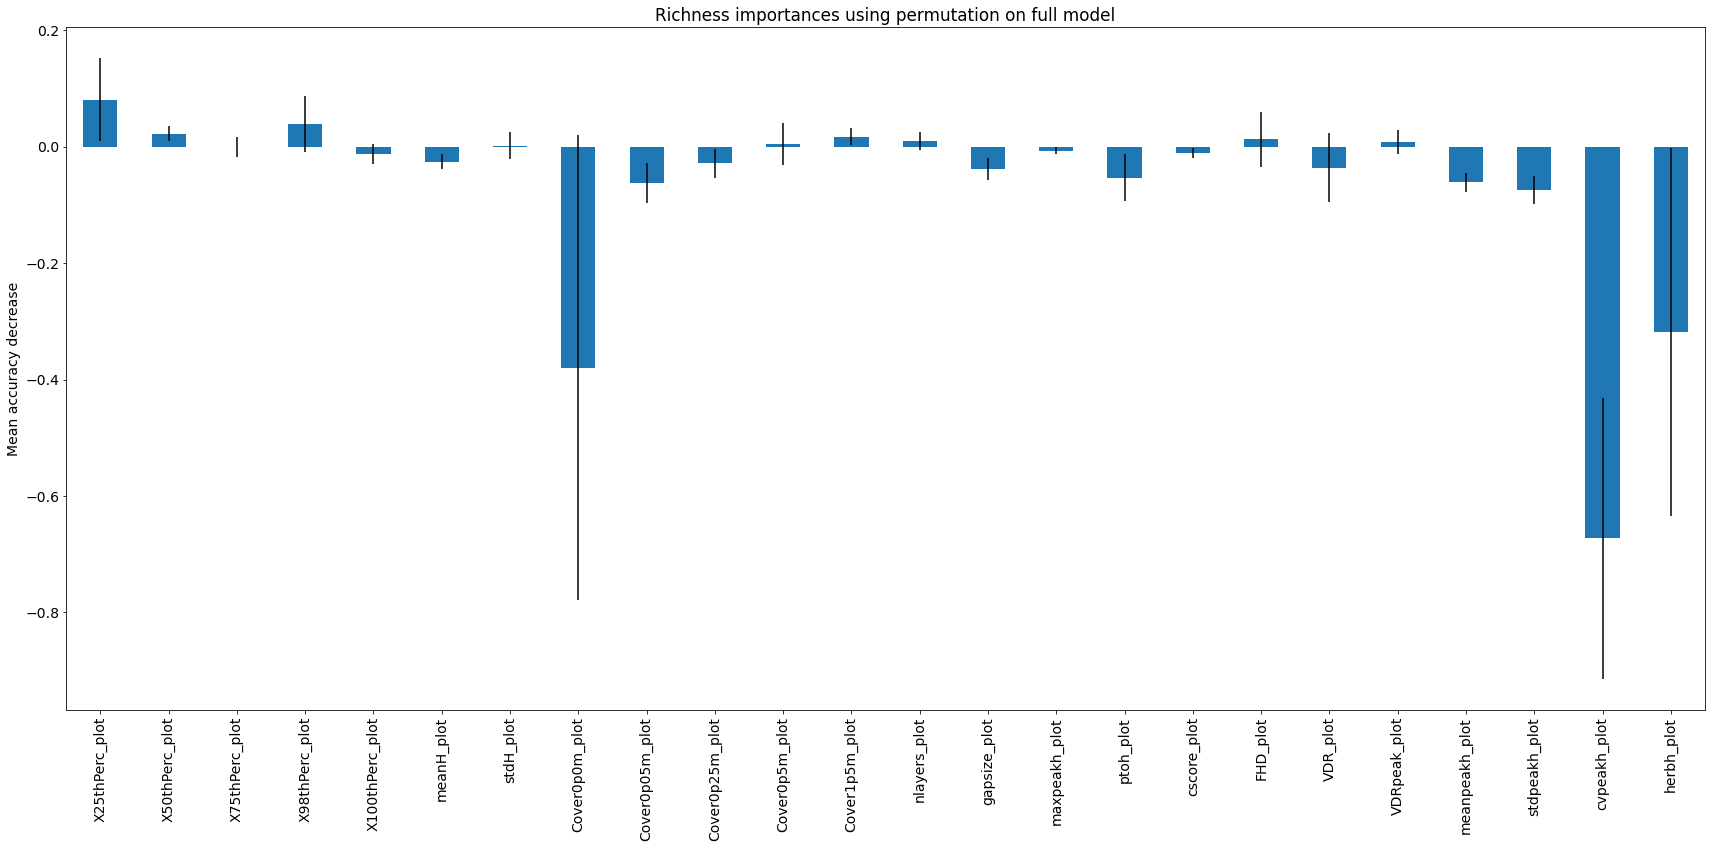




Richness MDI Top 6 X Vars:

	Cover0p0m_plot
	herbh_plot
	cvpeakh_plot
	ptoh_plot
	X98thPerc_plot
	Cover0p05m_plot
	X25thPerc_plot
	VDR_plot
	FHD_plot
	Cover0p25m_plot


Richness Permutation Top 6 X Vars:

	X25thPerc_plot
	X98thPerc_plot
	X50thPerc_plot
	Cover1p5m_plot
	FHD_plot
	nlayers_plot
	VDRpeak_plot
	Cover0p5m_plot
	stdH_plot
	X75thPerc_plot





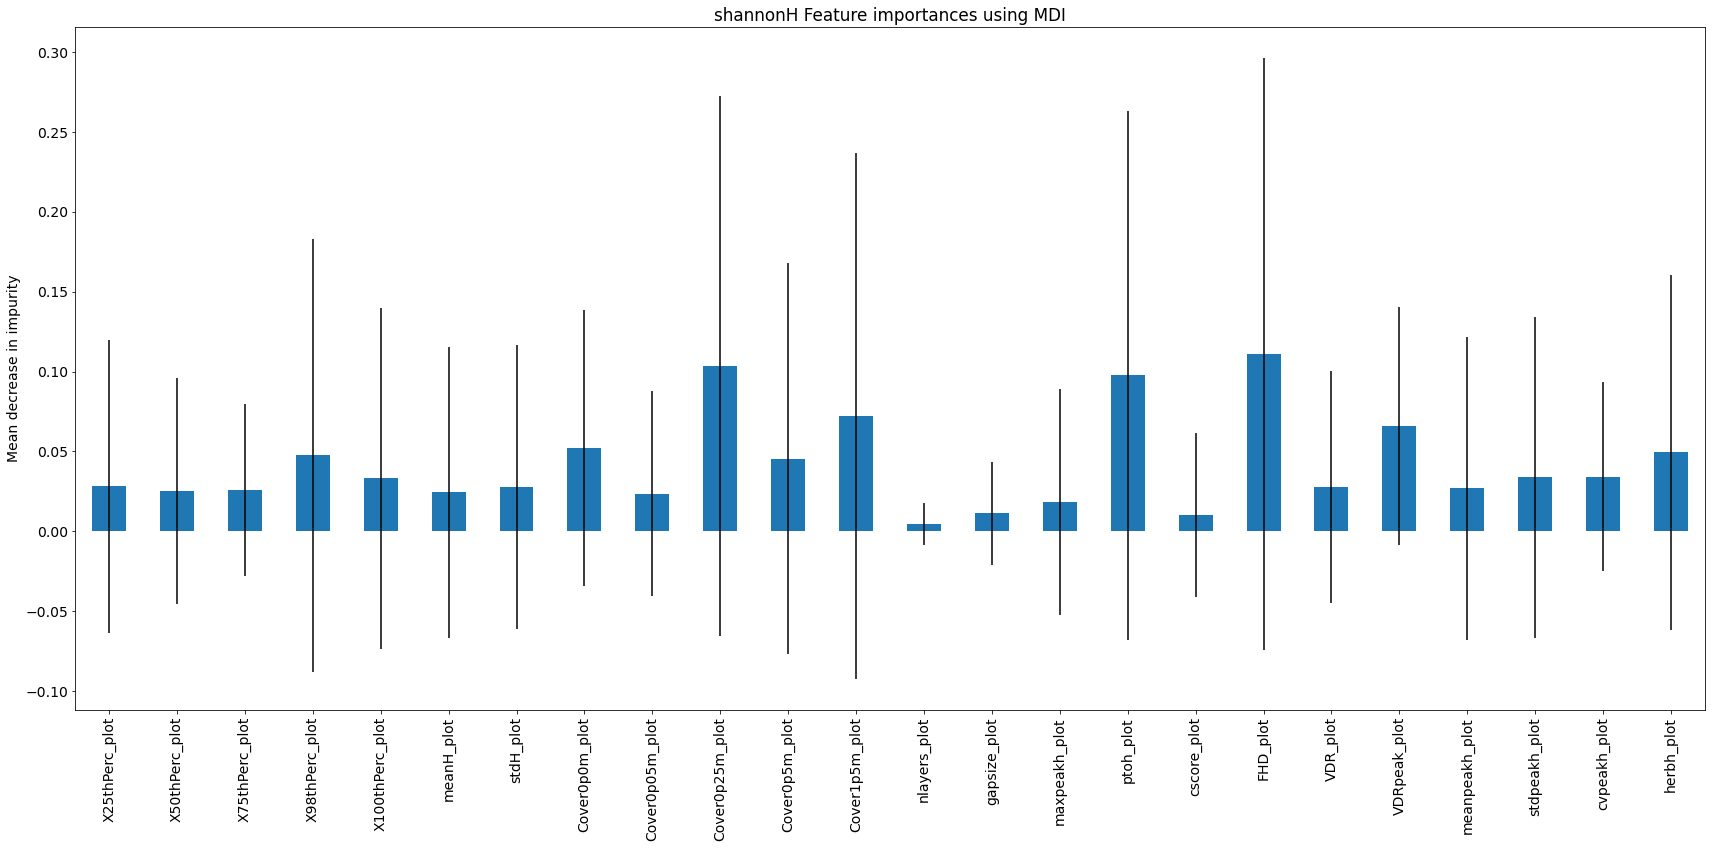

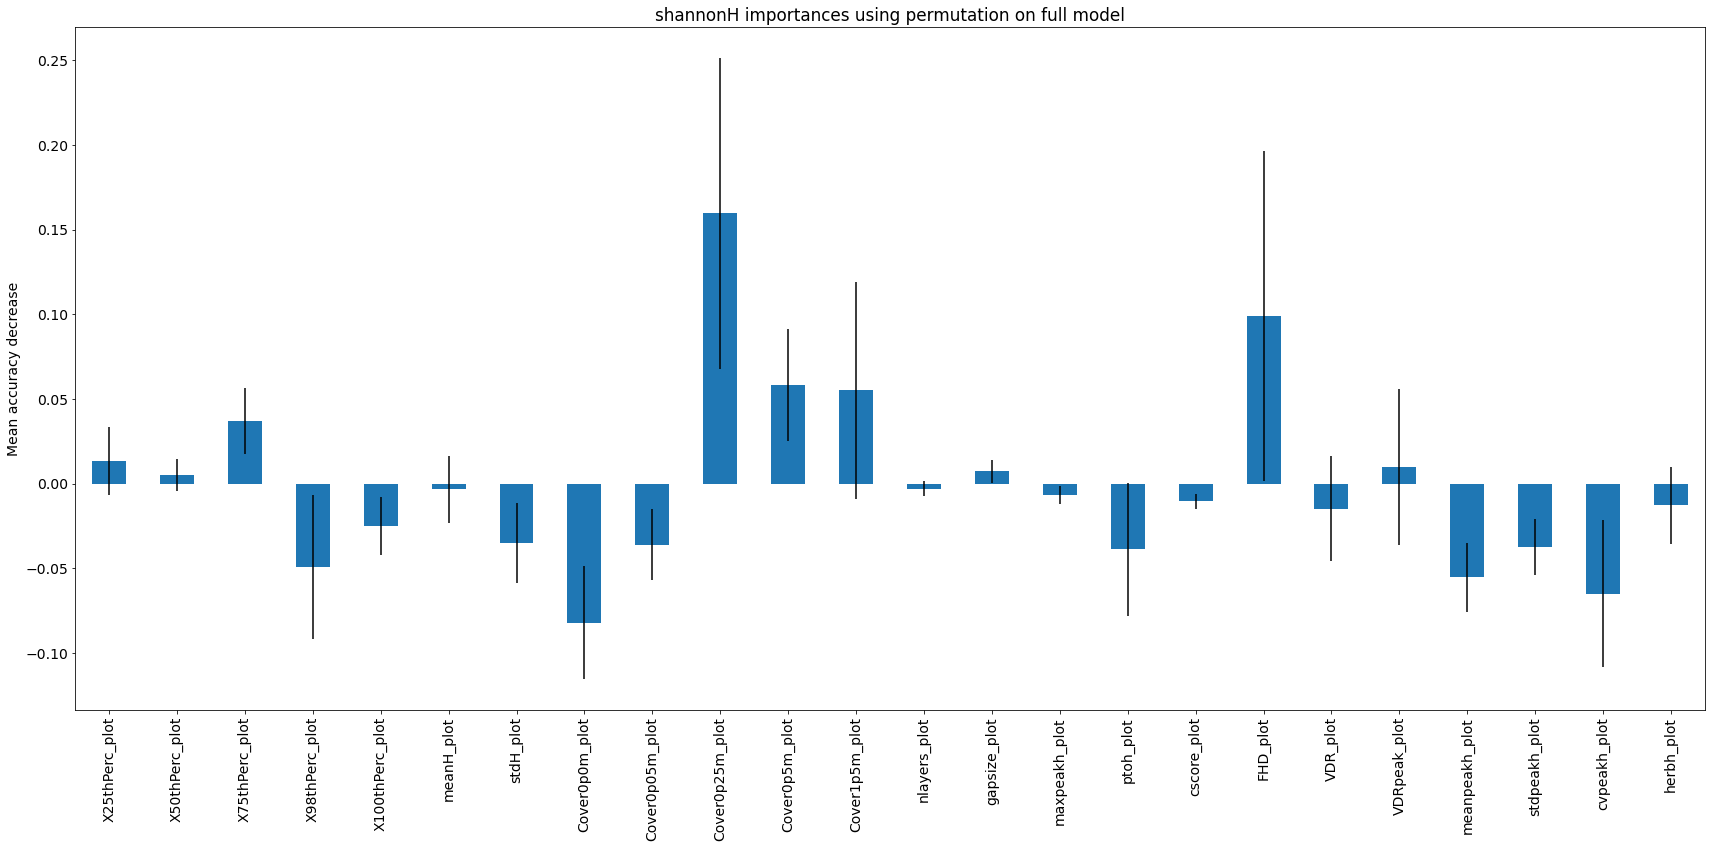




shannonH MDI Top 6 X Vars:

	FHD_plot
	Cover0p25m_plot
	ptoh_plot
	Cover1p5m_plot
	VDRpeak_plot
	Cover0p0m_plot
	herbh_plot
	X98thPerc_plot
	Cover0p5m_plot
	cvpeakh_plot


shannonH Permutation Top 6 X Vars:

	Cover0p25m_plot
	FHD_plot
	Cover0p5m_plot
	Cover1p5m_plot
	X75thPerc_plot
	X25thPerc_plot
	VDRpeak_plot
	gapsize_plot
	X50thPerc_plot
	nlayers_plot





In [12]:
# cols = [c for c in X.columns if not (('iqr' in c) | ('max_' in c) | ('Spot' in c))]
cols = [c for c in X.columns if 'plot' in c]
X_filter = X[cols]
# For all soils
for feat in ['Abundance', 'Richness', 'shannonH']:
    mdi_top10, permute_top10, fig1, ax1, fig, ax = featureSelectRF(X=X_filter,
                                                                   y=XY_scale[feat],
                                                                   feat=feat)